# Classificação

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import mlflow
from mlflow.models import infer_signature
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.impute import SimpleImputer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_histograms(df, column, category_col, bins, custom_labels=None):
    df_plot = df.copy()

    if custom_labels and category_col in custom_labels:
        label_list = custom_labels[category_col]
        unique_values = sorted(df_plot[category_col].dropna().unique())

        label_map = {val: label_list[i] for i, val in enumerate(unique_values) if i < len(label_list)}
        df_plot[category_col] = df_plot[category_col].map(label_map)

    plt.figure(figsize=(8, 5))
    sns.histplot(
        data=df_plot,
        x=column,
        hue=category_col,
        kde=True,
        bins=bins,
        palette='tab10',
        element='step',
        fill=True,
    )
    plt.title(f'Histograma de {column} por {category_col}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.show()
    print( ' ')

In [1]:
def plot_stacked_barplot(df, column, category_col=None, custom_labels=None):
    df_plot = df.copy()

    if custom_labels and column in custom_labels:
        label_list = custom_labels[column]
        unique_values = sorted(df_plot[column].dropna().unique())
        label_map = {val: label_list[i] for i, val in enumerate(unique_values) if i < len(label_list)}
        df_plot[column] = df_plot[column].map(label_map)

    if category_col and custom_labels and category_col in custom_labels:
        label_list = custom_labels[category_col]
        unique_values = sorted(df_plot[category_col].dropna().unique())
        label_map = {val: label_list[i] for i, val in enumerate(unique_values) if i < len(label_list)}
        df_plot[category_col] = df_plot[category_col].map(label_map)

    count_data = pd.crosstab(df_plot[column], df_plot[category_col])

    count_data.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='tab10')

    plt.title(f'Barras Empilhadas de {column}' + (f' por {category_col}' if category_col else ''))
    plt.xlabel(column)
    plt.ylabel('Contagem')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('')

In [4]:
def plot_boxplots_category(df, column, category_col, custom_labels=None):
    df_plot = df.copy()
    if custom_labels and category_col in custom_labels:
        label_list = custom_labels[category_col]
        unique_values = sorted(df_plot[category_col].dropna().unique())

        label_map = {val: label_list[i] for i, val in enumerate(unique_values) if i < len(label_list)}
        df_plot[category_col] = df_plot[category_col].map(label_map)

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_plot, x=category_col, y=column, hue=category_col, palette='tab10')
    plt.title(f'Boxplot de {column} por {category_col}')
    plt.xlabel(category_col)
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()
    print( ' ')

In [5]:
def plot_correlation_matrix(df):
    corr_df = df.select_dtypes(include=['float', 'int']).columns
    # Ensure the target column is included if it exists
    if 'classe_binaria' in df.columns:
        corr_df = corr_df.tolist()
        if 'classe_binaria' not in corr_df:
            corr_df.append('classe_binaria')
        corr_df = df[corr_df]
    else:
        corr_df = df[corr_df]

    plt.figure(figsize=(14, 12))
    correlation_matrix = corr_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
    plt.title('Matriz de Correlação')
    plt.show()

In [6]:
def remove_outliers_iqr(df, column, category_col=None):
    if category_col:
        filtered_df = pd.DataFrame()
        for category in df[category_col].unique():
            subset = df[df[category_col] == category]
            Q1 = subset[column].quantile(0.25)
            Q3 = subset[column].quantile(0.75)
            IQR = Q3 - Q1
            mask = (subset[column] >= Q1 - 1.5 * IQR) & (subset[column] <= Q3 + 1.5 * IQR)
            filtered_df = pd.concat([filtered_df, subset[mask]])
        return filtered_df
    else:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        mask = (df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)
        return df[mask]

In [8]:
df = pd.read_csv('../bootcamp_train.csv')

In [9]:
df

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35255,35255,L54709,L,300.1,311.4,90.0,1634.0,34.2,45.0,não,False,False,não,False,Não
35256,35256,L54735,L,300.4,311.3,90.0,1597.0,36.2,112.0,0,False,False,Não,False,Não
35257,35257,L54275,L,300.6,-38.0,90.0,1485.0,35.8,19.0,Não,False,False,Não,False,Não
35258,35258,M18165,M,301.3,310.4,90.0,1577.0,37.3,43.0,não,False,False,não,False,não


# Identificar valores nulos

In [10]:
df.isna().sum()

id                                   0
id_produto                           0
tipo                                 0
temperatura_ar                     616
temperatura_processo               599
umidade_relativa                     0
velocidade_rotacional              751
torque                             623
desgaste_da_ferramenta             952
falha_maquina                        0
FDF (Falha Desgaste Ferramenta)      0
FDC (Falha Dissipacao Calor)         0
FP (Falha Potencia)                  0
FTE (Falha Tensao Excessiva)         0
FA (Falha Aleatoria)                 0
dtype: int64

# Identificar o tipo dos dados

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               35260 non-null  int64  
 1   id_produto                       35260 non-null  object 
 2   tipo                             35260 non-null  object 
 3   temperatura_ar                   34644 non-null  float64
 4   temperatura_processo             34661 non-null  float64
 5   umidade_relativa                 35260 non-null  float64
 6   velocidade_rotacional            34509 non-null  float64
 7   torque                           34637 non-null  float64
 8   desgaste_da_ferramenta           34308 non-null  float64
 9   falha_maquina                    35260 non-null  object 
 10  FDF (Falha Desgaste Ferramenta)  35260 non-null  object 
 11  FDC (Falha Dissipacao Calor)     35260 non-null  object 
 12  FP (Falha Potencia

# Estatistica descritiva

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,35260.0,17629.500000,10178.829582,0.000000,8814.75,17629.5,26444.25,35259.000000
temperatura_ar,34644.0,269.535241,96.342224,-36.000000,297.90,299.6,301.10,304.500000
temperatura_processo,34661.0,280.457676,96.943630,-38.000000,308.50,309.8,310.90,313.800000
umidade_relativa,35260.0,89.997672,0.142191,80.590429,90.00,90.0,90.00,94.575256
velocidade_rotacional,34509.0,1380.194181,494.098759,-161.000000,1408.00,1483.0,1574.00,2886.000000
torque,34637.0,40.210357,8.831626,3.800000,34.30,40.3,46.20,76.600000
desgaste_da_ferramenta,34308.0,74.373266,110.411937,-202.000000,28.00,94.0,155.00,253.000000


# Frequencias das classes

- Colunas com alta cardinalidade não expressam um padrao e não ajudam no treinamento do modelo e portanto são removidas. As colunas id e id_produto se encaixam nessa situacao.

In [13]:
df.nunique()

id                                 35260
id_produto                          9708
tipo                                   3
temperatura_ar                        94
temperatura_processo                  83
umidade_relativa                      36
velocidade_rotacional                916
torque                               579
desgaste_da_ferramenta               247
falha_maquina                          8
FDF (Falha Desgaste Ferramenta)        6
FDC (Falha Dissipacao Calor)           6
FP (Falha Potencia)                    8
FTE (Falha Tensao Excessiva)           2
FA (Falha Aleatoria)                   7
dtype: int64

In [14]:
df.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


# As colunas referentes as falhas apresentaram diversos valores alem de sim e nao. Isso foi identificado e corrigido.

# coluna falha_maquina

In [15]:
df.falha_maquina.value_counts()

falha_maquina
Não    21926
não    11303
N        691
0        678
Sim      420
sim      217
y         13
1         12
Name: count, dtype: int64

In [16]:
df.falha_maquina.unique()

array(['não', 'Não', 'sim', 'N', '0', 'Sim', 'y', '1'], dtype=object)

In [18]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    'Não': 'nao', 'N': 'nao', '0': 'nao', 'não': 'nao',
    'Sim': 'sim', '1': 'sim', 'y': 'sim', 'sim': 'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['falha_maquina_map'] = df['falha_maquina'].map(mapeamento)

# Dataset desbalanceado

In [19]:
df.falha_maquina_map.value_counts()

falha_maquina_map
nao    34598
sim      662
Name: count, dtype: int64

In [20]:
# Checar se todas ocorrencias foram ajustadas
34598 + 662 # Total de linhas no dataset

35260

# Multiclasse - 5 tipos de falhas

# coluna FDF (Falha Desgaste Ferramenta)

In [21]:
df['FDF (Falha Desgaste Ferramenta)'].value_counts()

FDF (Falha Desgaste Ferramenta)
False    33729
N          702
0          688
True        70
-           70
1            1
Name: count, dtype: int64

In [22]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    'False': 'nao', 'N': 'nao', '0': 'nao',
    'True': 'sim', '1': 'sim', '-': 'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['FDF (Falha Desgaste Ferramenta)_map']= df['FDF (Falha Desgaste Ferramenta)'].map(mapeamento)

# Dataset desbalanceado

In [23]:
df['FDF (Falha Desgaste Ferramenta)_map'].value_counts()

FDF (Falha Desgaste Ferramenta)_map
nao    35119
sim      141
Name: count, dtype: int64

In [24]:
# Checar se todas ocorrencias foram ajustadas
35119 + 141 # Total de linhas no dataset

35260

# coluna FDC (Falha Dissipacao Calor)

In [25]:
df['FDC (Falha Dissipacao Calor)'].value_counts()

FDC (Falha Dissipacao Calor)
False    33649
nao        700
0          686
True       217
y            4
1            4
Name: count, dtype: int64

In [26]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    'False' : 'nao', 'nao': 'nao', '0': 'nao',
    'True': 'sim', 'y': 'sim', '1': 'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['FDC (Falha Dissipacao Calor)_map']= df['FDC (Falha Dissipacao Calor)'].map(mapeamento)

# Dataset desbalanceado

In [27]:
df['FDC (Falha Dissipacao Calor)_map'].value_counts()

FDC (Falha Dissipacao Calor)_map
nao    35035
sim      225
Name: count, dtype: int64

In [28]:
# Checar se todas ocorrencias foram ajustadas
35035 + 225 # Total de linhas no dataset

35260

# coluna FP (Falha Potencia)

In [29]:
df['FP (Falha Potencia)'].value_counts()

FP (Falha Potencia)
Não    22282
não    11462
N        702
0        688
Sim       81
sim       41
1          2
y          2
Name: count, dtype: int64

In [30]:
df['FP (Falha Potencia)'].unique()

array(['Não', 'não', 'Sim', 'N', '0', 'sim', '1', 'y'], dtype=object)

In [31]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    'Não': 'nao', 'não': 'nao', 'N':'nao', '0':'nao',
    'Sim': 'sim', 'sim': 'sim', '1': 'sim', 'y':'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['FP (Falha Potencia)_map']= df['FP (Falha Potencia)'].map(mapeamento)

# Dataset desbalanceado

In [32]:
df['FP (Falha Potencia)_map'].value_counts()

FP (Falha Potencia)_map
nao    35134
sim      126
Name: count, dtype: int64

In [33]:
# Checar se todas ocorrencias foram ajustadas
35134 + 126 # Total de linhas no dataset

35260

#  coluna FTE (Falha Tensao Excessiva)

In [34]:
df['FTE (Falha Tensao Excessiva)'].value_counts()

FTE (Falha Tensao Excessiva)
False    35090
True       170
Name: count, dtype: int64

In [35]:
df['FTE (Falha Tensao Excessiva)'].unique()

array([False,  True])

In [36]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    False: 'nao',
    True: 'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['FTE (Falha Tensao Excessiva)_map']= df['FTE (Falha Tensao Excessiva)'].map(mapeamento)

# Dataset desbalanceado

In [37]:
df['FTE (Falha Tensao Excessiva)_map'].value_counts()

FTE (Falha Tensao Excessiva)_map
nao    35090
sim      170
Name: count, dtype: int64

In [38]:
# Checar se todas ocorrencias foram ajustadas
35090 + 170 # Total de linhas no dataset

35260

# coluna FA (Falha Aleatoria)

In [39]:
df['FA (Falha Aleatoria)'].value_counts()

FA (Falha Aleatoria)
Não    22702
não    11712
0        702
-         70
Sim       49
sim       24
1          1
Name: count, dtype: int64

In [40]:
df['FA (Falha Aleatoria)'].unique()

array(['Não', 'não', '0', '-', 'Sim', 'sim', '1'], dtype=object)

In [41]:
# Mapear os valores para 'sim' e 'nao'
mapeamento = {
    'Não': 'nao', 'não': 'nao', '-':'nao', '0':'nao',
    'Sim': 'sim', 'sim': 'sim', '1': 'sim'
}

# Aplicar o mapeamento na coluna falha_maquina
df['FA (Falha Aleatoria)_map']= df['FA (Falha Aleatoria)'].map(mapeamento)

# Dataset desbalanceado

In [42]:
df['FA (Falha Aleatoria)_map'].value_counts()

FA (Falha Aleatoria)_map
nao    35186
sim       74
Name: count, dtype: int64

In [43]:
# Checar se todas ocorrencias foram ajustadas
35186 + 74 # Total de linhas no dataset

35260

# Colunas de indicadores de falha ajustadas para sim e nao

In [44]:
falhas = ['falha_maquina_map',
 'FDF (Falha Desgaste Ferramenta)_map',
 'FDC (Falha Dissipacao Calor)_map',
 'FP (Falha Potencia)_map',
 'FTE (Falha Tensao Excessiva)_map',
 'FA (Falha Aleatoria)_map']

# Percentual de exemplos com sim e nao

In [45]:
for coluna in falhas:
    print("Coluna (%):\n", df[coluna].value_counts(True) * 100, "\n-------------")

Coluna (%):
 falha_maquina_map
nao    98.122518
sim     1.877482
Name: proportion, dtype: float64 
-------------
Coluna (%):
 FDF (Falha Desgaste Ferramenta)_map
nao    99.600113
sim     0.399887
Name: proportion, dtype: float64 
-------------
Coluna (%):
 FDC (Falha Dissipacao Calor)_map
nao    99.361883
sim     0.638117
Name: proportion, dtype: float64 
-------------
Coluna (%):
 FP (Falha Potencia)_map
nao    99.642655
sim     0.357345
Name: proportion, dtype: float64 
-------------
Coluna (%):
 FTE (Falha Tensao Excessiva)_map
nao    99.517867
sim     0.482133
Name: proportion, dtype: float64 
-------------
Coluna (%):
 FA (Falha Aleatoria)_map
nao    99.79013
sim     0.20987
Name: proportion, dtype: float64 
-------------


# Classificacao Binaria

# As colunas referentes a falhas apresentam alta taxa de desbalanceamento.
# A tarefa de classificação pode ser feita em duas etapas.
# Treinar um modelo com um conjunto de dados que indica se existe falha ou nao. Dessa forma, podemos aplicar esse modelo para  identificar se um novo conjunto de dados indica falha ou não.
# Treinar um segundo modelo com apenas com dados indicando os 5 tipos de falhas. Dessa forma se um novo conjunto de dados foi classificado com falha pelo primeiro modelo, o segundo modelo pode classificar o tipo de falha.

# Será feito o treinamento e avaliação para classe binária apenas a coluna falha_maquina_map, que foi ajustada a partir da coluna falha_maquina original.

In [46]:
df2 = df [['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta', 'falha_maquina_map']].copy()

# Ajustar colunas com valores ausentes

In [47]:
colunas = df2.columns.tolist()
colunas

['id',
 'id_produto',
 'tipo',
 'temperatura_ar',
 'temperatura_processo',
 'umidade_relativa',
 'velocidade_rotacional',
 'torque',
 'desgaste_da_ferramenta',
 'falha_maquina_map']

# Identificar o percentual de dados ausentes

In [48]:
for col in colunas:
    total_linhas = df.shape[0]
    if df2[col].isna().sum() > 0:
      print("Colunas:",col)
      print(df2[col].isna().sum(), 'dados ausentes/nulos de  ',total_linhas)
      print('Taxa: ',round(df2[col].isna().sum()/total_linhas * 100,2), "% ")
      print(" ")

Colunas: temperatura_ar
616 dados ausentes/nulos de   35260
Taxa:  1.75 % 
 
Colunas: temperatura_processo
599 dados ausentes/nulos de   35260
Taxa:  1.7 % 
 
Colunas: velocidade_rotacional
751 dados ausentes/nulos de   35260
Taxa:  2.13 % 
 
Colunas: torque
623 dados ausentes/nulos de   35260
Taxa:  1.77 % 
 
Colunas: desgaste_da_ferramenta
952 dados ausentes/nulos de   35260
Taxa:  2.7 % 
 


# Aplicar o fillna nas colunas e preencher com o valor da mediana.
# Foi usada a mediana pois nao é impactada por outliers.

In [49]:
df3 = df2.copy()
print("Aplicar a mediana da coluna\n")
for col in colunas:
    total_linhas = df.shape[0]
    if df2[col].isna().sum() > 0:
      print("Colunas:",col)
      df3[col].fillna(df3[col].median(), inplace=True)



Aplicar a mediana da coluna

Colunas: temperatura_ar
Colunas: temperatura_processo
Colunas: velocidade_rotacional
Colunas: torque
Colunas: desgaste_da_ferramenta


In [50]:
df3.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina_map
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,nao
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,nao
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,nao
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,nao
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,94.0,nao


In [51]:
df3.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina_map
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,nao
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,nao
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,nao
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,nao
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,94.0,nao


# coluna falha_maquina_map, a classe binaria, sera convertida em numerica, para se ajustar o valor esperado por alguns modelos que serão treinados

In [52]:
le = LabelEncoder()
df3['falha_maquina_map'] = le.fit_transform(df3['falha_maquina_map'])

In [53]:
df3.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina_map
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,0
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,0
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,0
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,0
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,94.0,0


In [145]:
df_binario = df3.copy()
df_binario = df_binario.rename(columns={'falha_maquina_map': 'classe_binaria'})

In [146]:
df_binario.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,classe_binaria
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,0
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,0
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,0
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,0
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,94.0,0


In [147]:
df_binario.shape

(35260, 10)

# Visualizar a distribuicao de cada coluna

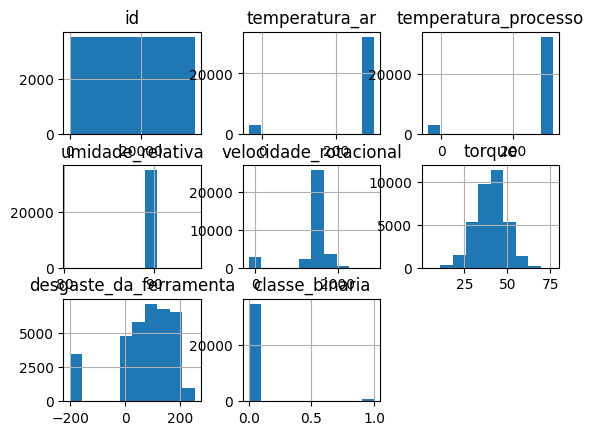

In [148]:
df_binario.hist();

In [149]:
numerical = df_binario.select_dtypes(include=np.number).columns.tolist()
categorical = df_binario.columns.difference(numerical).to_list()

In [150]:
print('Colunas numericas:', numerical)
print('Colunas categoricas:', categorical)

Colunas numericas: ['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'classe_binaria']
Colunas categoricas: ['id_produto', 'tipo']


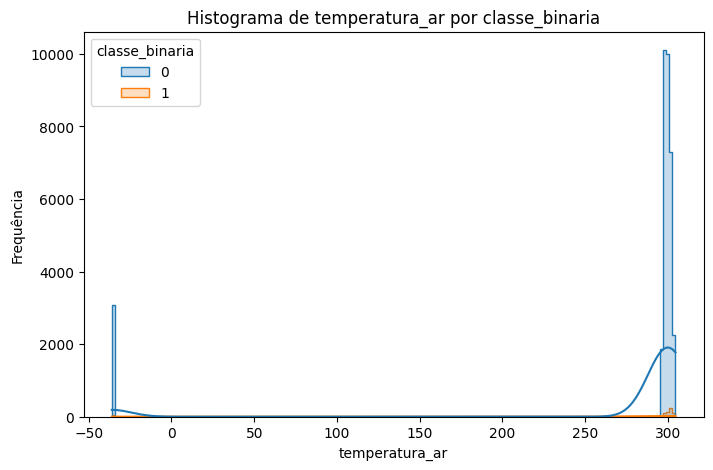

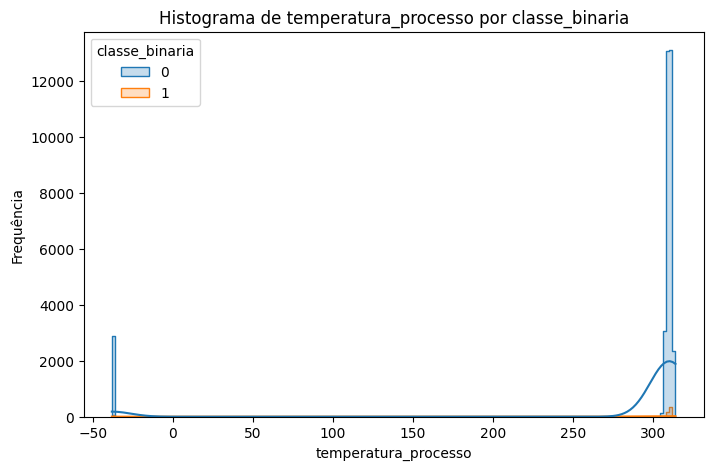

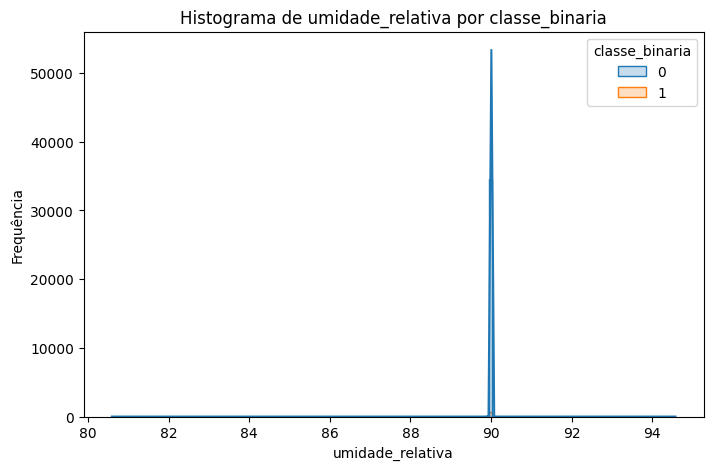

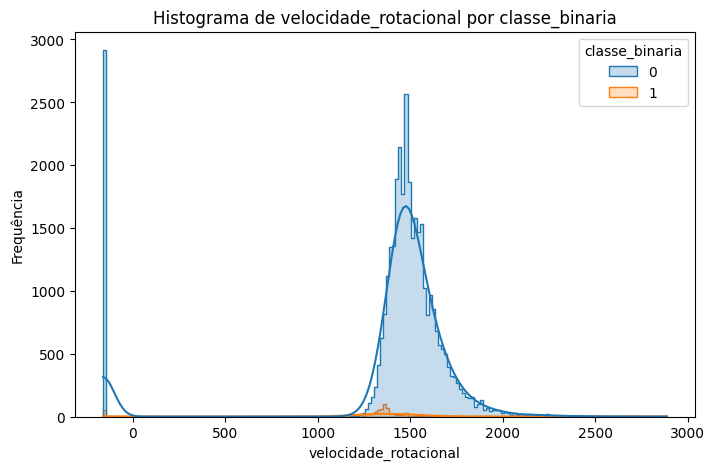

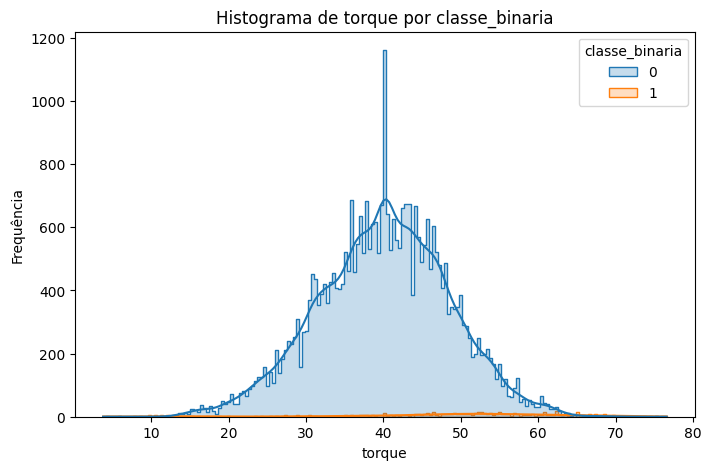

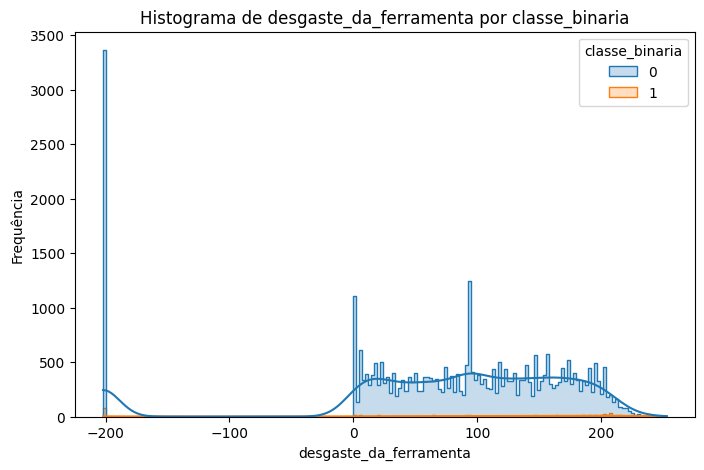

In [151]:
bins = int(np.sqrt(len(df_binario)))
for column in numerical:
  if column != 'classe_binaria' and column != 'id' and column != 'id_produto':
    plot_histograms(df_binario, column, 'classe_binaria', bins)

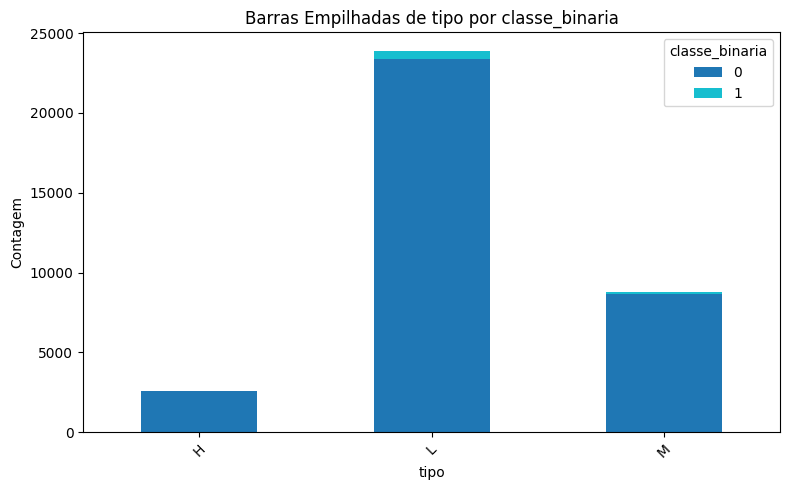

In [152]:
for column in categorical:
    if column != 'classe_binaria' and column != 'id_produto':
        plot_stacked_barplot(df_binario, column, 'classe_binaria')

# Boxplot
- identificar valores outliers, alem do limites aceitáveis.
- Limite definido pelos quartis gerados na distribuição dos dados.

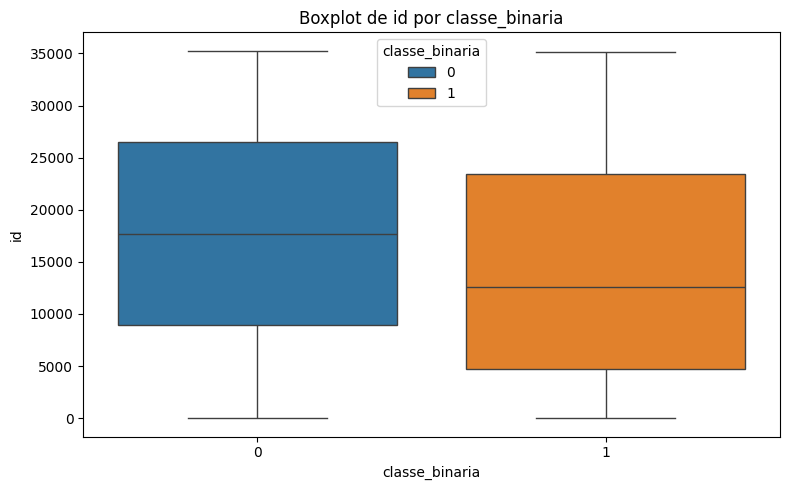

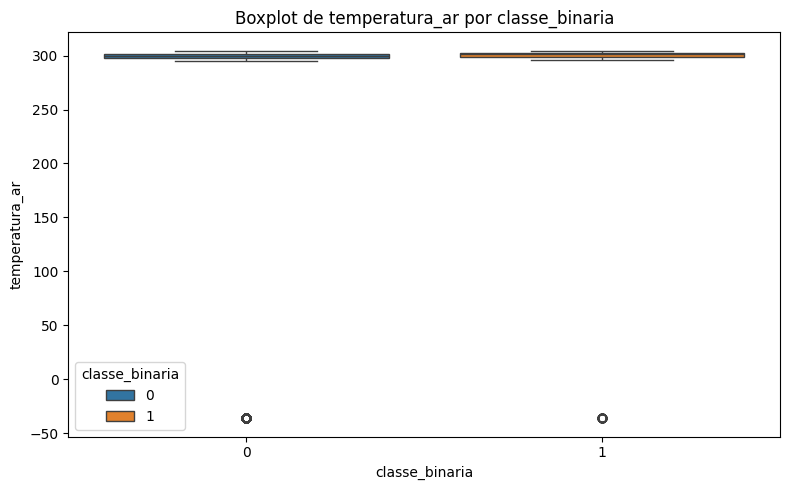

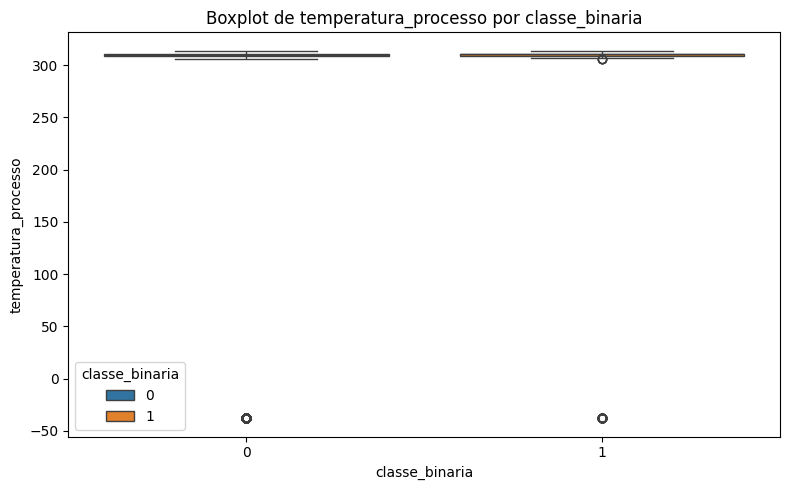

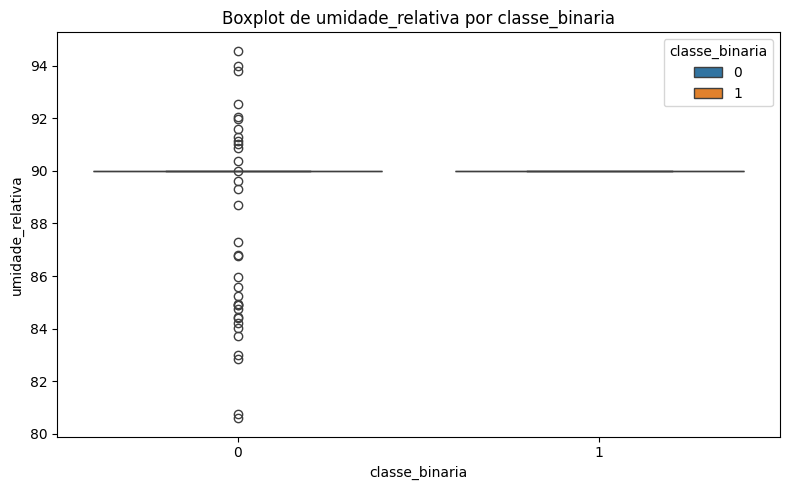

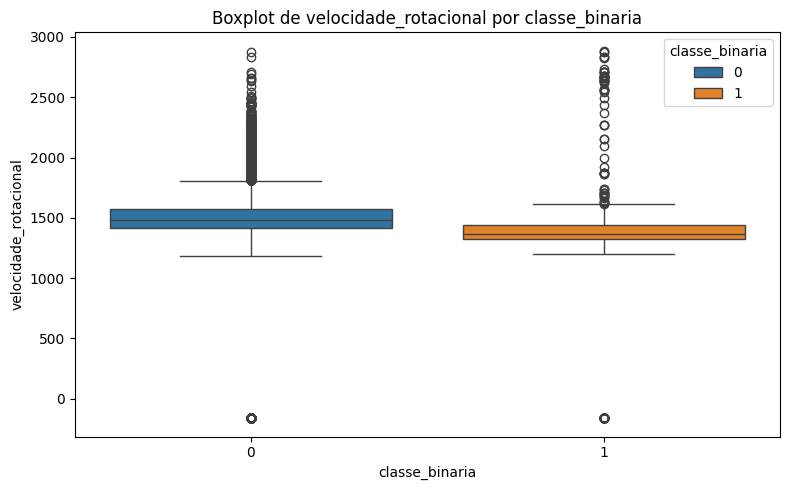

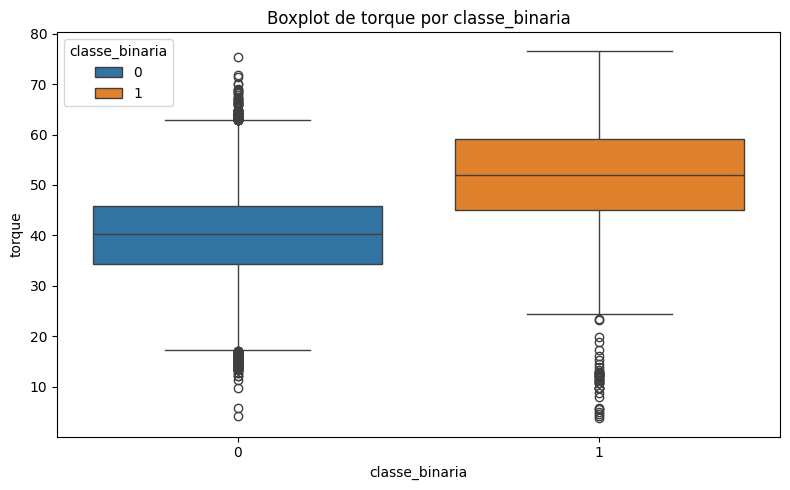

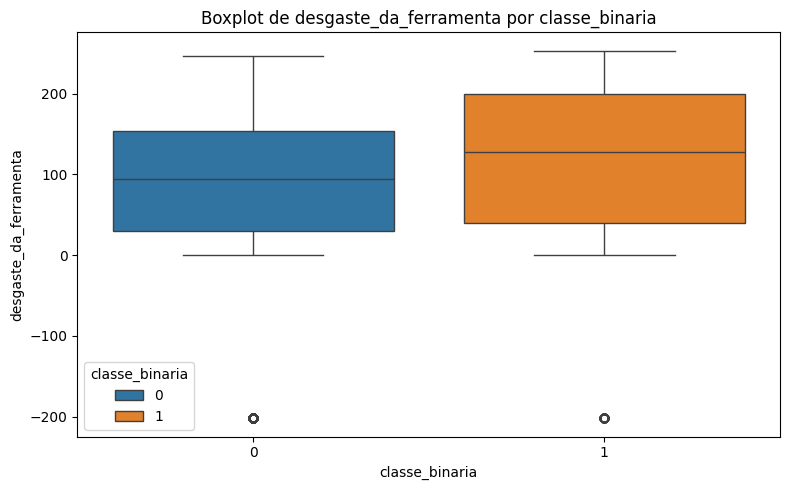

In [153]:
for column in numerical:
  if column != 'classe_binaria':
    plot_boxplots_category(df_binario, column, 'classe_binaria')

# Identificar correlação

In [154]:
# Select only numerical columns for correlation calculation
numerical_df = df_binario.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Get the correlation of each numerical column with 'classe_binaria'
correlation_with_classe_binaria = correlation_matrix['classe_binaria']

# Display the correlations
display(correlation_with_classe_binaria)

id                       -0.042439
temperatura_ar            0.011472
temperatura_processo      0.005853
umidade_relativa          0.002265
velocidade_rotacional    -0.009431
torque                    0.149400
desgaste_da_ferramenta    0.027612
classe_binaria            1.000000
Name: classe_binaria, dtype: float64

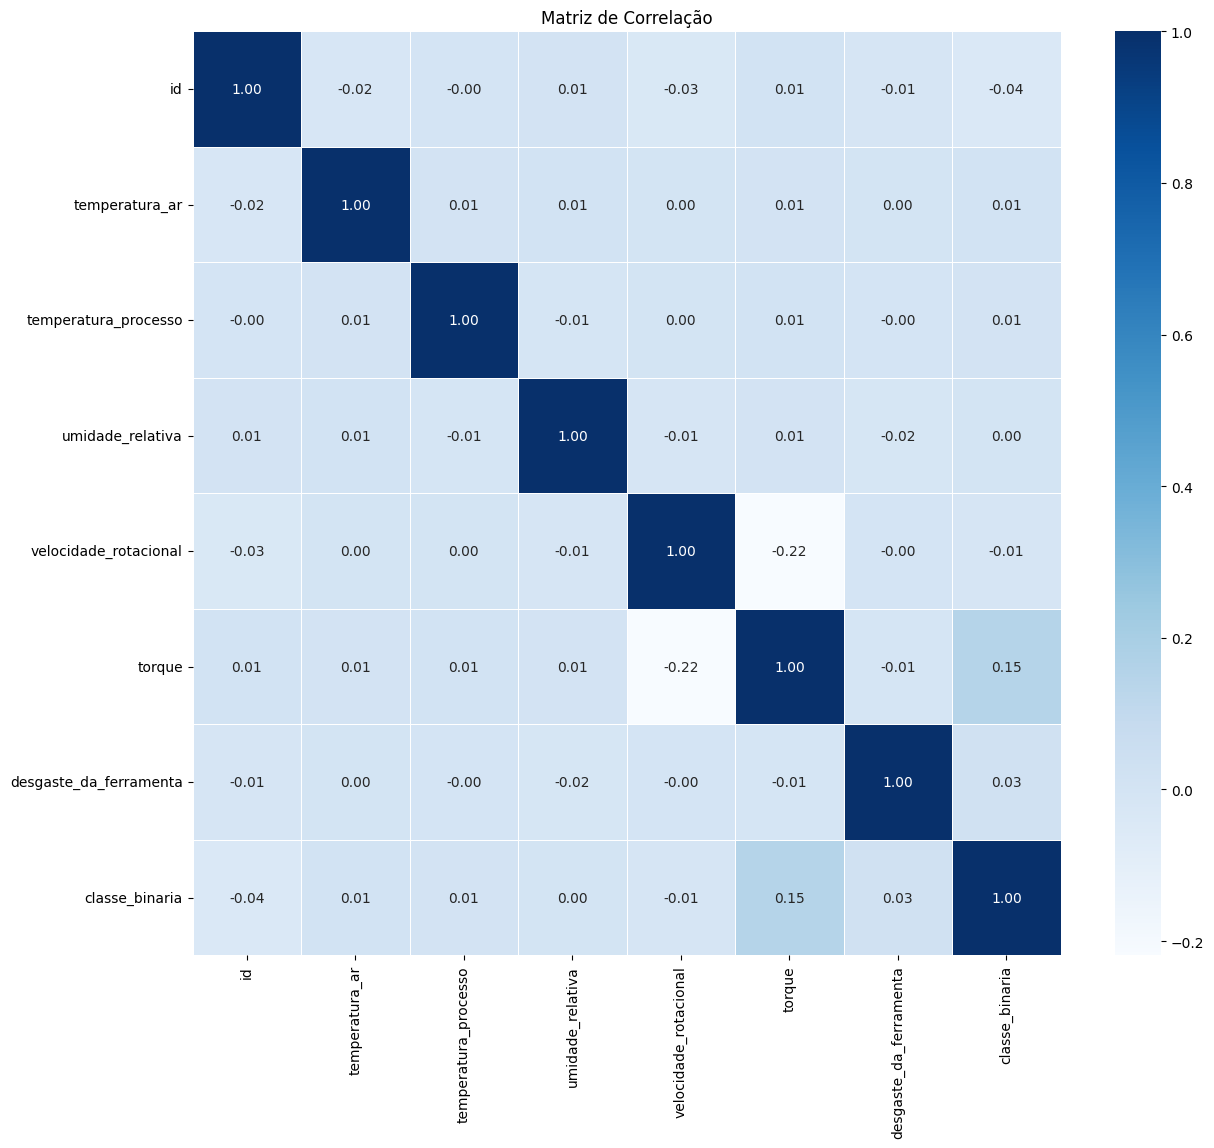

In [155]:
plot_correlation_matrix(df_binario)

# DATASET DESBALANCEADO

# Checar distribuição das classes

In [156]:
df_binario.classe_binaria.value_counts()

classe_binaria
0    34598
1      662
Name: count, dtype: int64

In [157]:
# Checar se todas ocorrencias foram ajustadas
34598 + 662 # Total de linhas no dataset

35260

# Identificar e remover Outliers

In [158]:
print("Antes:", df_binario.shape)

Antes: (35260, 10)


In [159]:
# Criar uma cópia do DataFrame para não modificar o original diretamente
df_cleaned = df_binario.copy()

# Identificar as colunas numéricas, excluindo 'GradeClass' pois será a coluna categoria
numerical_cols_for_outliers = df_cleaned.select_dtypes(include=np.number).columns.tolist()
if 'classe_binaria' in numerical_cols_for_outliers:
    numerical_cols_for_outliers.remove('classe_binaria')

print(f"Colunas numéricas para detecção de outliers por classe_binaria:\n{numerical_cols_for_outliers}")

# Aplicar a remoção de outliers para cada coluna numérica, considerando GradeClass
for col in numerical_cols_for_outliers:
    initial_rows = len(df_cleaned)
    df_cleaned = remove_outliers_iqr(df_cleaned, col, 'classe_binaria')
    removed_rows = initial_rows - len(df_cleaned)
    print(f"Após remover outliers em '{col}' por classe_binaria: {len(df_cleaned)} linhas restantes ({removed_rows} removidas)")

print("\nDataFrame após remover outliers de todas as colunas numéricas por classe_binaria:")
display(df_cleaned.head())
print(f"\nShape final do DataFrame: {df_cleaned.shape}")

Colunas numéricas para detecção de outliers por classe_binaria:
['id', 'temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
Após remover outliers em 'id' por classe_binaria: 35260 linhas restantes (0 removidas)
Após remover outliers em 'temperatura_ar' por classe_binaria: 32128 linhas restantes (3132 removidas)
Após remover outliers em 'temperatura_processo' por classe_binaria: 29467 linhas restantes (2661 removidas)
Após remover outliers em 'umidade_relativa' por classe_binaria: 29448 linhas restantes (19 removidas)
Após remover outliers em 'velocidade_rotacional' por classe_binaria: 25784 linhas restantes (3664 removidas)
Após remover outliers em 'torque' por classe_binaria: 25692 linhas restantes (92 removidas)
Após remover outliers em 'desgaste_da_ferramenta' por classe_binaria: 23228 linhas restantes (2464 removidas)

DataFrame após remover outliers de todas as colunas numéricas por classe_binaria:


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,classe_binaria
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,0
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,0
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,94.0,0
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,0
7,7,L55125,L,300.8,311.7,90.0,1655.0,32.2,12.0,0



Shape final do DataFrame: (23228, 10)


# Treinamento dos modelos

# Dividir conjunto das variaveis dependentes e independentes.

In [160]:
X = df_cleaned.drop(['id', 'id_produto', 'classe_binaria'], axis=1).copy() # Independentes
y = df_cleaned.classe_binaria.copy() # Dependentes

In [161]:
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

In [162]:
print("Colunas numericas:", numeric_cols, "\nColunas categoricas:", categorical_cols)

Colunas numericas: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta'] 
Colunas categoricas: ['tipo']


# Dividir em treino e teste

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [164]:
X_train.shape, X_test.shape

((18582, 7), (4646, 7))

# Baseline
- metricas
- precision_recall_curve
- matriz de confusao
- salvos pelo mlflow

In [173]:
from sklearn.dummy import DummyClassifier
import mlflow
from mlflow.models import infer_signature
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve


# Função para logar matriz de confusão
def log_confusion_matrix(y_true, y_pred, nome_modelo, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.ylabel("Verdadeiro")
    plt.xlabel("Previsto")
    plt.tight_layout()
    path = f"report_binario\BASELINE\confusion_matrix_{nome_modelo}.png"
    plt.savefig(path)
    mlflow.log_artifact(path)
    plt.close()


# Função auxiliar para logar no MLflow
def avaliar_e_logar_baseline(model, nome_execucao, X_train, y_train, X_test, y_test, labels):
    with mlflow.start_run(run_name=nome_execucao):
        # Make predictions
        y_pred = model.predict(X_test)

        # Get predicted probabilities for precision-recall curve if available
        y_scores = None
        if hasattr(model, "predict_proba"):
             y_scores = model.predict_proba(X_test)[:, 1] # Get probabilities for the positive class (class 1)

        # Calculate metrics
        report_dict = classification_report(y_test, y_pred, target_names=[str(l) for l in labels], output_dict=True)

        # Log metrics
        mlflow.log_metric("accuracy", report_dict.get('accuracy', 0.0))

        # Log precision, recall, and f1-score for the positive class (binary average)
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1)

        # Safely access metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1-score", f1)


        # Log classification report as artifact
        df_report = pd.DataFrame(report_dict).transpose()
        csv_path = f"classification_report\BASELINE_binario_{nome_execucao}.csv"
        df_report.to_csv(csv_path)
        mlflow.log_artifact(csv_path)

        # Log confusion matrix
        log_confusion_matrix(y_test, y_pred, nome_execucao, [str(l) for l in labels])

        # Generate and log precision-recall curve if probabilities are available
        if y_scores is not None:
            precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_scores)
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {nome_execucao}')
            plt.grid(True)
            pr_curve_path = f"report_binario\\BASELINE\\precision_recall_curve_{nome_execucao}.png"
            plt.savefig(pr_curve_path)
            mlflow.log_artifact(pr_curve_path)
            plt.close()


        print(f"\n### {nome_execucao} ###")
        print(classification_report(y_test, y_pred, target_names=[str(l) for l in labels]))

        mlflow.end_run()

# ================================
# Executar experimentos e salvar no MLflow
# ================================
mlflow.set_experiment("Baseline binario")

one = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = one.fit_transform(X_train)
X_test_encoded = one.transform(X_test)

labels = ['nao', 'sim'] # Assuming this is consistent with your LabelEncoder mapping

# Baseline 1: sempre prever a classe majoritária
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_encoded, y_train)
avaliar_e_logar_baseline(dummy, "DummyClassifier_Baseline", X_train_encoded, y_train, X_test_encoded, y_test, labels)


# Baseline 2: Logistic Regression sem ajuste
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)
avaliar_e_logar_baseline(model, "LogisticRegression_Baseline", X_train_encoded, y_train, X_test_encoded, y_test, labels)


### DummyClassifier_Baseline ###
              precision    recall  f1-score   support

         nao       0.98      1.00      0.99      4553
         sim       0.00      0.00      0.00        93

    accuracy                           0.98      4646
   macro avg       0.49      0.50      0.49      4646
weighted avg       0.96      0.98      0.97      4646


### LogisticRegression_Baseline ###
              precision    recall  f1-score   support

         nao       0.98      1.00      0.99      4553
         sim       0.80      0.09      0.16        93

    accuracy                           0.98      4646
   macro avg       0.89      0.54      0.57      4646
weighted avg       0.98      0.98      0.97      4646



In [74]:
#Counter(y_train)
# Counter({0: 27678, 1: 530})

# Treinamento e avaliacao com MLFlow

# Foram treinados 5 modelos.
# Os hiperparametros foram ajustados para o dataset desbalanceado.
- metricas
- precision_recall_curve
- matriz de confusao
- salvos pelo mlflow
# Estrategias:
- sem smote   - classes desbalanceadas
- com smote   - classes iguais
- scale_pos_weight - ajuste do peso das classes
- sample_weights   - ajuste do peso das classes
- class_weigt: 'balanced'

In [174]:
# ================================
# Função para logar matriz de confusão
# ================================
def log_confusion_matrix(y_true, y_pred, nome_modelo, estrategia, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusão - {nome_modelo}_{estrategia}")
    plt.ylabel("Verdadeiro")
    plt.xlabel("Previsto")
    plt.tight_layout()
    # Use nome_modelo for the path
    path = f"report_binario\confusion_matrix_{nome_modelo}_{estrategia}.png"
    plt.savefig(path)
    mlflow.log_artifact(path)
    plt.close()

# Função auxiliar para logar no MLflow
# --------------------------
# Added 'model' parameter to pass the actual fitted model object
def avaliar_e_logar(model_pipeline, nome_execucao, X_train, y_train, X_test, y_test, resultados, labels, apply_smote=False):
    with mlflow.start_run(run_name=nome_execucao):
        # Apply preprocessing
        print("Preprocessing...OneHot e MinMax")
        X_train_processed = model_pipeline.named_steps['preprocessing'].fit_transform(X_train)
        X_test_processed = model_pipeline.named_steps['preprocessing'].transform(X_test)

        classifier = model_pipeline.named_steps['classifier']
        print("Model:", classifier.__class__.__name__)

        # Determine training data based on apply_smote flag
        if apply_smote:
            print("Applying SMOTE...")
            smote = SMOTE(random_state=42)
            X_fit, y_fit = smote.fit_resample(X_train_processed, y_train)
            print("SMOTE applied.")
            estrategia = 'Smote'
            print("Estrategia:", estrategia)
        else:
            X_fit, y_fit = X_train_processed, y_train.copy()
            estrategia = 'sem_smote'
            print("Estrategia:", estrategia)

            # Print specific hyperparameters for verification (when not using SMOTE)
            if isinstance(classifier, (XGBClassifier, RandomForestClassifier)):
                if hasattr(classifier, 'scale_pos_weight'):
                     print(f"\nXGBoost - Ajustar pesos das classes com scale_pos_weight: {classifier.get_params().get('scale_pos_weight')}")
                     # If using scale_pos_weight, the strategy is scale_pos_weight
                     estrategia = 'scale_pos_weight' if isinstance(classifier, XGBClassifier) else estrategia
                     print("Estrategia:",estrategia)
                if hasattr(classifier, 'class_weight') and classifier.get_params().get('class_weight') == 'balanced':
                     print(f"RandomForest class_weight: {classifier.get_params().get('class_weight')}")
                     # If using class_weight='balanced', the strategy is class_weight
                     estrategia = 'class_weight' if isinstance(classifier, RandomForestClassifier) else estrategia
                     print("Estrategia:",estrategia)


        # Treina o pipeline
        print("Training...")
        # Fit the classifier using the appropriate data (X_fit, y_fit)
        if classifier.__class__.__name__ == 'GradientBoostingClassifier' and not apply_smote :
             # Apply sample weights only when not using SMOTE for GradientBoosting
             classifier.fit(X_fit, y_fit, sample_weight=compute_sample_weight(class_weight='balanced', y=y_fit))
             print("GradientBoostingClassifier with sample_weights")
             estrategia = 'sample_weights' # Update strategy if sample_weights is used
             print("Estrategia:",estrategia)
        else:
             # Fit all other models, including GB when using SMOTE
             classifier.fit(X_fit, y_fit)




        # Infer signature AFTER fitting
        input_example = X_train[:5] # Use original X_train for input example
        input_example_processed = model_pipeline.named_steps['preprocessing'].transform(input_example) # Preprocess the input example
        signature = infer_signature(input_example_processed, model_pipeline.named_steps['classifier'].predict(input_example_processed))


        mlflow.sklearn.log_model(
            sk_model=model_pipeline.named_steps['classifier'], # Log only the classifier
            name="model", # Define an artifact path
            signature=signature,
            input_example=input_example_processed # Use processed input example for logging
        )


        # Make predictions using the fitted pipeline
        y_pred = model_pipeline.named_steps['classifier'].predict(X_test_processed)

        # Get predicted probabilities for precision-recall curve
        y_scores = None
        if hasattr(classifier, "predict_proba"):
             y_scores = classifier.predict_proba(X_test_processed)[:, 1] # Get probabilities for the positive class (class 1)


        # Calculate metrics
        acc = accuracy_score(y_test, y_pred)
        # Calculate precision, recall, f1-score for the positive class (binary average)
        precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)


        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1-score", f1)
        print("\nMetricas: accuracy, precision, recall e f1-score  salvas no mlflow")

        # Relatório detalhado (by class)
        # Use the labels passed to the function
        report_dict = classification_report(y_test, y_pred, target_names=[str(l) for l in labels], output_dict=True)
        df_report = pd.DataFrame(report_dict).transpose()


        print("\nMatriz de confusao salva no mlflow\n")
        # Use nome_execucao for the CSV path
        csv_path = f"classification_report\Binario_{nome_execucao}_{estrategia}.csv"
        df_report.to_csv(csv_path)
        mlflow.log_artifact(csv_path)

        # Matriz de confusão
        # Pass nome_execucao as nome_modelo
        log_confusion_matrix(y_test, y_pred, nome_execucao, estrategia, [str(l) for l in labels])

        # Generate and log precision-recall curve if probabilities are available
        if y_scores is not None:
            precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_scores)
            plt.figure(figsize=(8, 6))
            plt.plot(recall_curve, precision_curve, marker='.')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve - {nome_execucao}_{estrategia}')
            plt.grid(True)
            pr_curve_path = f"report_binario\precision_recall_curve_{nome_execucao}_{estrategia}.png"
            plt.savefig(pr_curve_path)
            mlflow.log_artifact(pr_curve_path)
            plt.close()
            print(f"Precision_Recall_Curve salva no mlflow")


        # Guardar para ranking final (include per-class metrics)
        # Safely access metrics for class '1' for the result_entry
        class_1_metrics_for_results = report_dict.get('1', {})
        result_entry = {
            "Modelo": nome_execucao,
            "Accuracy": acc,
            # Use the directly calculated metrics for the results dataframe
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            'Estrategia': estrategia.upper()
        }


        resultados.append(result_entry)


        # Show in console
        print(f"\n### {nome_execucao} ###")
        print(classification_report(y_test, y_pred, target_names=[str(l) for l in labels]))

        mlflow.end_run()
# Calcule os pesos da amostra
# 'balanced' ajusta os pesos inversamente proporcionais à frequência das classes
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Compute the positive class weight
# Counter(y_train)
# Counter({0: 27678, 1: 530})
pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train) # 27678 / 530

#print("Pos class weight:",pos_class_weight)
# ================================
# Lista de modelos a testar
# ================================
modelos = {
    'KNN': KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=100),
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42), # No smote class_weigt= 'None'
    "GradientBoosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', scale_pos_weight=pos_class_weight),
}

labels = le.classes_


# ================================
# Executar experimentos e salvar no MLflow
# ================================
mlflow.set_experiment("Classe binaria")

resultados = []
# ================================
# Executar experiments and log to MLflow
# ================================
n=1

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough' # Keep other columns (if any, though none expected here)
)

for nome, modelo in modelos.items():
    print("Modelo", n, "de", len(modelos))
    n+=1

    print(f"\n### Executing {nome} ###")

    # Create a pipeline for the current model
    model_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', modelo) # Use the model instance from the dictionary
    ])

    # 1) Without balancing
    print("\nWithout balancing")
    # Pass the pipeline instance to the function
    #avaliar_e_logar(model_pipeline, f"{nome}_sem_balanceamento", X_train, y_train, X_test, y_test, resultados, labels, apply_smote=False)
    avaliar_e_logar(model_pipeline, f"{nome}", X_train, y_train, X_test, y_test, resultados, labels, apply_smote=False)


    # 2) With SMOTE (Skip SMOTE for XGBoost as it uses scale_pos_weight)
    if not isinstance(modelo, XGBClassifier):
        print("With SMOTE")
        # Special handling for RandomForest with SMOTE: set class_weight to None
        if isinstance(modelo, RandomForestClassifier):
             model_pipeline.named_steps['classifier'].set_params(class_weight=None)
             print("RandomForest class_weight set to None for SMOTE.")

        # Pass the pipeline instance and resampled data to the function
        #avaliar_e_logar(model_pipeline, f"{nome}_com_SMOTE", X_train, y_train, X_test, y_test, resultados, labels, apply_smote=True)
        avaliar_e_logar(model_pipeline, f"{nome}", X_train, y_train, X_test, y_test, resultados, labels, apply_smote=True)



    print("\n------------------------------\n")

# ================================
# Ranking final em Pandas
# ================================
df_resultados = pd.DataFrame(resultados).sort_values(by="F1-score", ascending=False)
print("\n🏆 Ranking dos modelos:")
print(df_resultados)

Modelo 1 de 5

### Executing KNN ###

Without balancing
Preprocessing...OneHot e MinMax
Model: KNeighborsClassifier
Estrategia: sem_smote
Training...

Metricas: accuracy, precision, recall e f1-score  salvas no mlflow

Matriz de confusao salva no mlflow

Precision_Recall_Curve salva no mlflow

### KNN ###
              precision    recall  f1-score   support

         nao       0.99      1.00      0.99      4553
         sim       0.76      0.28      0.41        93

    accuracy                           0.98      4646
   macro avg       0.88      0.64      0.70      4646
weighted avg       0.98      0.98      0.98      4646

With SMOTE
Preprocessing...OneHot e MinMax
Model: KNeighborsClassifier
Applying SMOTE...
SMOTE applied.
Estrategia: Smote
Training...

Metricas: accuracy, precision, recall e f1-score  salvas no mlflow

Matriz de confusao salva no mlflow

Precision_Recall_Curve salva no mlflow

### KNN ###
              precision    recall  f1-score   support

         nao       0

# A metrica definida como objetivo foi Recall.
# No contexto onde os dados foram coletados, uma linha de produção, o custo de uma maquina quebrada por alguma falha foi considerado alto.
# Um Recall alto, pode gerar falsos positivos, o que iria gerar uma paralização para manutenção, caso seja um alarme falso, isso seria menos impactante do que se tivesse que trocar alguma peça defeituosa, sendo a parada considerada uma manutenção preventiva. A metrica usada pode ser alterada para precision ou f1-score ao longo do tempo de acordo com as prioridades definidas pela empresa.

In [175]:
df_resultados = pd.DataFrame(resultados).sort_values(by="Recall", ascending=False).reset_index()
print("\n🏆 Ranking dos modelos:")
colunas = ['Modelo', 'Recall','Precision', 'F1-score', 'Estrategia']
print(df_resultados[colunas])


🏆 Ranking dos modelos:
               Modelo    Recall  Precision  F1-score        Estrategia
0    GradientBoosting  0.838710   0.202073  0.325678    SAMPLE_WEIGHTS
1    GradientBoosting  0.817204   0.190476  0.308943             SMOTE
2  LogisticRegression  0.806452   0.085812  0.155119             SMOTE
3                 KNN  0.688172   0.195719  0.304762             SMOTE
4             XGBoost  0.666667   0.596154  0.629442  SCALE_POS_WEIGHT
5        RandomForest  0.623656   0.449612  0.522523             SMOTE
6        RandomForest  0.430108   0.851064  0.571429      CLASS_WEIGHT
7                 KNN  0.279570   0.764706  0.409449         SEM_SMOTE
8  LogisticRegression  0.043011   0.800000  0.081633         SEM_SMOTE


In [176]:
best_model = df_resultados.loc[0, 'Modelo']
print("Melhor modelo:", best_model)

Melhor modelo: GradientBoosting


# Avaliacao com dados de teste

In [80]:
df_test = pd.read_csv('../bootcamp_test.csv')

In [81]:
df_test.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
0,35260,L53432,L,300.8,310.3,90.0,1538,36.1,198
1,35261,M19544,M,303.6,311.8,90.0,1421,44.8,101
2,35262,M16591,M,298.3,307.9,90.0,1485,42.0,117
3,35263,L51922,L,303.3,311.3,90.0,1592,33.7,14
4,35264,L51701,L,302.4,310.4,90.0,1865,23.9,129


In [82]:
df_test.columns

Index(['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta'],
      dtype='object')

In [83]:
df_test_processed = df_test.drop(['id','id_produto'], axis=1)

In [84]:
df_test_processed

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
0,L,300.8,310.3,90.0,1538,36.1,198
1,M,303.6,311.8,90.0,1421,44.8,101
2,M,298.3,307.9,90.0,1485,42.0,117
3,L,303.3,311.3,90.0,1592,33.7,14
4,L,302.4,310.4,90.0,1865,23.9,129
...,...,...,...,...,...,...,...
7168,L,300.3,311.7,90.0,1501,38.2,24
7169,L,300.4,311.4,90.0,1362,39.6,129
7170,M,297.9,309.1,90.0,1741,28.6,30
7171,L,297.0,307.7,90.0,1417,44.7,126


In [85]:
pred = np.round(model_pipeline.predict_proba(df_test_processed),2)

In [86]:
print("Probabilidade:", pred)

Probabilidade: [[1.   0.  ]
 [0.98 0.02]
 [1.   0.  ]
 ...
 [1.   0.  ]
 [1.   0.  ]
 [1.   0.  ]]


# Best model from mlflow

In [87]:
# Best model
best_gb_sample_weights_row = df_resultados[
    (df_resultados['Modelo'] == 'GradientBoosting') &
    (df_resultados['Estrategia'] == 'SAMPLE_WEIGHTS')
].iloc[0]

# Get the run_id from the original runs DataFrame based on the model and strategy
# We need to search the original runs DataFrame to find the run_id that corresponds
# to the GradientBoosting model run with the 'SAMPLE_WEIGHTS' strategy.
# We can do this by filtering the original runs DataFrame by run name and potentially
# by looking at the logged metrics (like recall_1) to match the best model from df_resultados.

# Let's get all runs for the "Classe binaria" experiment again to ensure we have the latest.
experiment_name = "Classe binaria"
all_runs = mlflow.search_runs(experiment_names=[experiment_name])

# Find the run_id in all_runs that corresponds to the best_gb_sample_weights_row
# We can filter by run name and then find the run that has the matching metrics (e.g., recall_1)
# This is a bit indirect, but based on the available tags, filtering by run name and then finding the best one is the most feasible.
gb_runs = all_runs[all_runs['tags.mlflow.runName'] == 'GradientBoosting']

# From the gb_runs, find the one that corresponds to the best_gb_sample_weights_row
# We can match by the recall_1 metric, assuming recall_1 was logged for these runs.
best_run_id = gb_runs[gb_runs['metrics.recall'] == best_gb_sample_weights_row['Recall']].iloc[0].run_id


print(f"Run ID do melhor GradientBoosting com sample_weights: {best_run_id}")

# Load the best classifier model (since the full pipeline wasn't logged)
# The artifact path was set to "model" in the avaliar_e_logar function
loaded_classifier = mlflow.sklearn.load_model(f"runs:/{best_run_id}/model")

# Recreate the preprocessor using the same settings as during training
# Make sure numeric_cols and categorical_cols are defined and correct
numeric_cols = df_test_processed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_test_processed.select_dtypes(exclude=np.number).columns.tolist()


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data to learn the transformations (important!)
# We need X_train from the previous steps. Make sure it's available in the environment.
# If X_train is not available, you would need to load it or re-run the previous steps.
# Assuming X_train is available:
preprocessor.fit(X_train)


# Apply the preprocessor to the test data
df_test_processed_transformed = preprocessor.transform(df_test_processed)


# Make predictions of probabilities on the preprocessed test data using the loaded classifier
# Get the probabilities for the positive class (class 1)
prediction_probabilities = loaded_classifier.predict_proba(df_test_processed_transformed)[:, 1]


# You can display the predictions
print("\nPrevisões de probabilidade de falha no dataset de teste:")
display(prediction_probabilities)

Run ID do melhor GradientBoosting com sample_weights: ba166c3a3ed7415884bafd5025d12887

Previsões de probabilidade de falha no dataset de teste:


array([0.2525423 , 0.26266959, 0.01717639, ..., 0.00934603, 0.03500102,
       0.07836984], shape=(7173,))

In [88]:
df_test.columns

Index(['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta'],
      dtype='object')

In [89]:
# Add the prediction probabilities to the original test DataFrame
df_test['probabilidade_falha (%)'] = prediction_probabilities * 100
df_test.sort_values(by='probabilidade_falha (%)', ascending=False, inplace=True)

# Display the updated test DataFrame with the probabilities
print("DataFrame de teste com as probabilidades de falha:")
display(df_test[['id', 'id_produto', 'probabilidade_falha (%)']])

DataFrame de teste com as probabilidades de falha:


,id,id_produto,probabilidade_falha (%)
2842,38102,L51574,99.599149
326,35586,L51310,99.548087
2000,37260,L51328,99.436189
3974,39234,L51962,99.404067
5952,41212,M18884,99.375449
...,...,...,...
5685,40945,L55041,0.575666
6914,42174,M22722,0.523045
1562,36822,M22597,0.523045
544,35804,H37296,0.523045


# Treinar modelo GradientBoostingClassifier e aplicar a estrategia

In [90]:
# Load the test data
df_test = pd.read_csv('../bootcamp_test.csv')

# Drop 'id' and 'id_produto' columns from the test data
df_test_processed = df_test.drop(['id','id_produto'], axis=1)

# Recreate the preprocessor using the same settings as during training
# Make sure numeric_cols and categorical_cols are defined and correct
numeric_cols = df_test_processed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_test_processed.columns.difference(numeric_cols).to_list()
if 'classe_binaria' in numeric_cols:
    numeric_cols.remove('classe_binaria')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

# Fit the preprocessor on the training data to learn the transformations
# Assuming X_train is available from previous steps
X_train_processed = preprocessor.fit_transform(X_train)

# Apply the preprocessor to the test data
df_test_processed_transformed = preprocessor.transform(df_test_processed)

# Define the best model with the appropriate strategy
best_model_no_mlflow = GradientBoostingClassifier()

# Calculate sample weights for the training data
# Assuming y_train is available from previous steps
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train the best model using the preprocessed training data and sample weights
print("Treinando o modelo GradientBoosting com sample_weights...")
best_model_no_mlflow.fit(X_train_processed, y_train, sample_weight=sample_weights)
print("Treinamento concluído.")

# Make predictions of probabilities on the preprocessed test data
prediction_probabilities_no_mlflow = best_model_no_mlflow.predict_proba(df_test_processed_transformed)[:, 1]

# Add the prediction probabilities to the original test DataFrame
df_test['probabilidade_falha (%)'] = prediction_probabilities_no_mlflow * 100
df_test.sort_values(by='probabilidade_falha (%)', ascending=False, inplace=True)

# Display the updated test DataFrame with the probabilities
print("\nDataFrame de teste com as probabilidades de falha (sem MLflow):")
display(df_test[['id', 'id_produto', 'probabilidade_falha (%)']])

Treinando o modelo GradientBoosting com sample_weights...
Treinamento concluído.

DataFrame de teste com as probabilidades de falha (sem MLflow):


,id,id_produto,probabilidade_falha (%)
2842,38102,L51574,99.599149
326,35586,L51310,99.548087
2000,37260,L51328,99.436189
3974,39234,L51962,99.404067
5952,41212,M18884,99.375449
...,...,...,...
5685,40945,L55041,0.575666
6914,42174,M22722,0.523045
1562,36822,M22597,0.523045
544,35804,H37296,0.523045


# Multiclasse

In [91]:
df.isna().sum()

id                                       0
id_produto                               0
tipo                                     0
temperatura_ar                         616
temperatura_processo                   599
umidade_relativa                         0
velocidade_rotacional                  751
torque                                 623
desgaste_da_ferramenta                 952
falha_maquina                            0
FDF (Falha Desgaste Ferramenta)          0
FDC (Falha Dissipacao Calor)             0
FP (Falha Potencia)                      0
FTE (Falha Tensao Excessiva)             0
FA (Falha Aleatoria)                     0
falha_maquina_map                        0
FDF (Falha Desgaste Ferramenta)_map      0
FDC (Falha Dissipacao Calor)_map         0
FP (Falha Potencia)_map                  0
FTE (Falha Tensao Excessiva)_map         0
FA (Falha Aleatoria)_map                 0
dtype: int64

In [92]:
df_falhas = df[['id', 'id_produto','falha_maquina_map', 'FDF (Falha Desgaste Ferramenta)_map',
                       'FDC (Falha Dissipacao Calor)_map',
                       'FP (Falha Potencia)_map',
                       'FTE (Falha Tensao Excessiva)_map',
                       'FA (Falha Aleatoria)_map']]
df_falhas_sim = df_falhas.loc[df_falhas['falha_maquina_map'] == 'sim']
df_falhas_sim.drop('falha_maquina_map', axis=1, inplace=True)

# Amostras filtradas pela coluna falha_maquina indicando que existe alguma falha.

In [93]:
df_falhas_sim

,id,id_produto,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map
11,11,L47348,nao,nao,sim,nao,nao
42,42,H33769,nao,sim,nao,nao,nao
148,148,L55379,sim,nao,nao,nao,nao
214,214,M19461,nao,sim,nao,nao,nao
233,233,M18317,nao,nao,sim,nao,nao
...,...,...,...,...,...,...,...
34956,34956,M19124,nao,sim,nao,nao,nao
35027,35027,L48825,nao,nao,sim,nao,nao
35083,35083,H32278,nao,nao,nao,nao,nao
35098,35098,L48172,nao,nao,nao,sim,nao


In [94]:
# Select the columns representing individual failure types
individual_failures_sim_cols = ['id', 'id_produto', 'FDF (Falha Desgaste Ferramenta)_map',
                               'FDC (Falha Dissipacao Calor)_map',
                               'FP (Falha Potencia)_map',
                               'FTE (Falha Tensao Excessiva)_map',
                               'FA (Falha Aleatoria)_map']

# Count the number of 'sim' occurrences in each row for these columns
df_falhas_sim['sim_count'] = df_falhas_sim[individual_failures_sim_cols].apply(
    lambda row: (row == 'sim').sum(), axis=1
)

# Display rows where sim_count is greater than 1
multilabel_cases = df_falhas_sim[df_falhas_sim['sim_count'] > 1]

print("Casos com múltiplos tipos de falha (mais de um 'sim' por linha):")
display(multilabel_cases)

print("\nContagem total de 'sim' por linha:")
display(df_falhas_sim['sim_count'].value_counts())

Casos com múltiplos tipos de falha (mais de um 'sim' por linha):


,id,id_produto,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map,sim_count
989,989,L47249,nao,nao,sim,sim,nao,2
1247,1247,L51597,nao,sim,sim,nao,nao,2
2862,2862,L51427,sim,sim,nao,nao,nao,2
2953,2953,H35323,sim,nao,sim,sim,nao,3
3219,3219,L51563,nao,sim,nao,sim,nao,2
3509,3509,L50791,sim,nao,nao,nao,sim,2
3645,3645,L51550,nao,sim,nao,sim,nao,2
3695,3695,L51642,nao,sim,nao,sim,nao,2
5102,5102,M20254,nao,nao,sim,sim,nao,2
5441,5441,M23786,nao,nao,sim,sim,nao,2



Contagem total de 'sim' por linha:


sim_count
1    554
0     89
2     18
3      1
Name: count, dtype: int64

In [95]:
df_falhas_sim.loc[df_falhas_sim['sim_count'] == 3]

,id,id_produto,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map,sim_count
2953,2953,H35323,sim,nao,sim,sim,nao,3


# Nas amostras onde aparece mais de um 'sim' indicando um tipo de falha.
# A amostra sera atribuida a falha que apresentar o primeiro 'sim' na respectiva linha.

In [96]:
# Filter df_falhas_sim to include only rows with at least one 'sim'
df_multiclasse_temp = df_falhas_sim[df_falhas_sim['sim_count'] > 0].copy()


# Define the individual failure columns
individual_failures_cols = ['FDF (Falha Desgaste Ferramenta)_map',
                           'FDC (Falha Dissipacao Calor)_map',
                           'FP (Falha Potencia)_map',
                           'FTE (Falha Tensao Excessiva)_map',
                           'FA (Falha Aleatoria)_map']

# Identificar o primeiro sim na linha da amostra
def get_failure_type(row):
    for col in individual_failures_cols:
        if row[col] == 'sim':
            return col  # Return the column name as the failure type
    return 'nao_especificada' # Should not happen if sim_count > 0, but as a fallback

df_multiclasse_temp['tipo_falha'] = df_multiclasse_temp.apply(get_failure_type, axis=1)


# Merge
df_multiclasse = df.loc[df_multiclasse_temp.index].copy()

# Add the 'tipo_falha' column from the temporary DataFrame to the final df_multiclasse DataFrame
df_multiclasse['tipo_falha'] = df_multiclasse_temp['tipo_falha']

# Proxima analise
df_multilabel = df_multiclasse.copy()

# Display the first few rows and the value counts of the new target column
print("DataFrame preparado para classificação multiclasse:")
display(df_multiclasse.head())

print("\nContagem dos tipos de falha para classificação multiclasse:")
display(df_multiclasse['tipo_falha'].value_counts())

DataFrame preparado para classificação multiclasse:


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,...,FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria),falha_maquina_map,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map,tipo_falha
11,11,L47348,L,298.4,308.3,90.0,1433.0,62.3,20.0,sim,...,Sim,False,0,sim,nao,nao,sim,nao,nao,FP (Falha Potencia)_map
42,42,H33769,H,302.0,309.8,90.0,1280.0,57.3,147.0,sim,...,Não,False,não,sim,nao,sim,nao,nao,nao,FDC (Falha Dissipacao Calor)_map
148,148,L55379,L,299.2,310.7,90.0,1737.0,27.0,225.0,Sim,...,Não,False,Não,sim,sim,nao,nao,nao,nao,FDF (Falha Desgaste Ferramenta)_map
214,214,M19461,M,303.0,311.1,90.0,1372.0,54.3,117.0,Sim,...,Não,False,Não,sim,nao,sim,nao,nao,nao,FDC (Falha Dissipacao Calor)_map
233,233,M18317,M,301.5,310.4,90.0,2639.0,12.0,21.0,sim,...,Sim,False,Não,sim,nao,nao,sim,nao,nao,FP (Falha Potencia)_map



Contagem dos tipos de falha para classificação multiclasse:


tipo_falha
FDC (Falha Dissipacao Calor)_map       221
FTE (Falha Tensao Excessiva)_map       153
FP (Falha Potencia)_map                124
FDF (Falha Desgaste Ferramenta)_map     74
FA (Falha Aleatoria)_map                 1
Name: count, dtype: int64

In [97]:
df_multiclasse.columns

Index(['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta', 'falha_maquina',
       'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
       'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)',
       'FA (Falha Aleatoria)', 'falha_maquina_map',
       'FDF (Falha Desgaste Ferramenta)_map',
       'FDC (Falha Dissipacao Calor)_map', 'FP (Falha Potencia)_map',
       'FTE (Falha Tensao Excessiva)_map', 'FA (Falha Aleatoria)_map',
       'tipo_falha'],
      dtype='object')

In [98]:
df_multiclasse.shape

(573, 22)

In [99]:
colunas = ['tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta',
       'tipo_falha']

In [100]:
df_multiclasse = df_multiclasse[colunas]

In [177]:
df_multiclasse.head()

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,tipo_falha
11,L,298.4,308.3,90.0,1433.0,62.3,20.0,2
42,H,302.0,309.8,90.0,1280.0,57.3,147.0,0
148,L,299.2,310.7,90.0,1737.0,27.0,225.0,1
214,M,303.0,311.1,90.0,1372.0,54.3,117.0,0
233,M,301.5,310.4,90.0,2639.0,12.0,21.0,2


In [178]:
df_multiclasse.tipo_falha.value_counts()

tipo_falha
0    221
3    153
2    124
1     74
Name: count, dtype: int64

# Remover a linha referente a falha FA(FalhaAleatoria) pois como a divisao em treino e teste sera estratificada, a ocorrencia unica devera ser removida.

In [179]:
df_multiclasse = df_multiclasse.loc[df_multiclasse['tipo_falha'] != 'FA (Falha Aleatoria)_map']

In [180]:
df_multiclasse.tipo_falha.value_counts()

tipo_falha
0    221
3    153
2    124
1     74
Name: count, dtype: int64

In [181]:
# Separate features (X_multi) and target (y_multi) for multiclass classification
X_multi = df_multiclasse.drop('tipo_falha', axis=1).copy()
y_multi = df_multiclasse['tipo_falha'].copy()

# Identify numerical and categorical columns in the multiclass features
numeric_cols_multi = X_multi.select_dtypes(include=np.number).columns.tolist()
categorical_cols_multi = X_multi.columns.difference(numeric_cols_multi).to_list()

print("Features para classificação multiclasse (X_multi):")
display(X_multi.head())
print("\nAlvo para classificação multiclasse (y_multi):")
display(y_multi.head())
print("\nColunas numéricas para multiclasse:", numeric_cols_multi)
print("Colunas categóricas para multiclasse:", categorical_cols_multi)
print("X multiclasse:", X_multi.shape)
print("y multiclasse:", y_multi.shape)

Features para classificação multiclasse (X_multi):


,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
11,L,298.4,308.3,90.0,1433.0,62.3,20.0
42,H,302.0,309.8,90.0,1280.0,57.3,147.0
148,L,299.2,310.7,90.0,1737.0,27.0,225.0
214,M,303.0,311.1,90.0,1372.0,54.3,117.0
233,M,301.5,310.4,90.0,2639.0,12.0,21.0



Alvo para classificação multiclasse (y_multi):


11     2
42     0
148    1
214    0
233    2
Name: tipo_falha, dtype: int64


Colunas numéricas para multiclasse: ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta']
Colunas categóricas para multiclasse: ['tipo']
X multiclasse: (572, 7)
y multiclasse: (572,)


# Aplicar labelencoder em tipo_falha

In [107]:
le_multi = LabelEncoder()
df_multiclasse['tipo_falha'] = le_multi.fit_transform(df_multiclasse['tipo_falha'])

# Dividir em X e y

In [108]:
X_multi = df_multiclasse.drop('tipo_falha', axis=1).copy()
y_multi = df_multiclasse['tipo_falha'].copy()

In [109]:
# Split the multiclass data into training and testing sets using the cleaned data
# We are using X_multi_processed_cleaned and y_multi_cleaned
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print("Dados multiclasse divididos em treino e teste (após pré-processamento com imputação e remoção da classe minoritária):")
print("X_multi_train shape:", X_multi_train.shape)
print("X_multi_test shape:", X_multi_test.shape)
print("y_multi_train shape:", y_multi_train.shape)
print("y_multi_test shape:", y_multi_test.shape)

print("\nDistribuição das classes em y_multi_train:")
display(y_multi_train.value_counts())
print("\nDistribuição das classes em y_multi_test:")
display(y_multi_test.value_counts())

Dados multiclasse divididos em treino e teste (após pré-processamento com imputação e remoção da classe minoritária):
X_multi_train shape: (457, 7)
X_multi_test shape: (115, 7)
y_multi_train shape: (457,)
y_multi_test shape: (115,)

Distribuição das classes em y_multi_train:


tipo_falha
0    177
3    122
2     99
1     59
Name: count, dtype: int64


Distribuição das classes em y_multi_test:


tipo_falha
0    44
3    31
2    25
1    15
Name: count, dtype: int64

# Baseline Multiclasse

In [182]:
from sklearn.dummy import DummyClassifier
import mlflow
from mlflow.models import infer_signature
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression # Import LogisticRegression


# Função para logar matriz de confusão
def log_confusion_matrix(y_true, y_pred, nome_modelo, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusão - {nome_modelo}")
    plt.ylabel("Verdadeiro")
    plt.xlabel("Previsto")
    plt.tight_layout()
    path = f"report_multiclasse\BASELINE\confusion_matrix_{nome_modelo}.png"
    plt.savefig(path)
    mlflow.log_artifact(path)
    plt.close()


# Função auxiliar para logar no MLflow
def avaliar_e_logar_baseline(model, nome_execucao, X_train, y_train, X_test, y_test, labels):
    with mlflow.start_run(run_name=nome_execucao):
        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        # Use weighted average for precision, recall, and f1-score in multiclass
        acc = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("weighted_precision", precision)
        mlflow.log_metric("weighted_recall", recall)
        mlflow.log_metric("weighted_f1-score", f1)


        # Log classification report as artifact
        report_dict = classification_report(y_test, y_pred, target_names=[str(l) for l in labels], output_dict=True, zero_division=0)
        df_report = pd.DataFrame(report_dict).transpose()
        csv_path = f"report_multiclasse\BASELINE\classification_report_{nome_execucao}.csv"
        df_report.to_csv(csv_path)
        mlflow.log_artifact(csv_path)

        # Log confusion matrix
        log_confusion_matrix(y_test, y_pred, nome_execucao, [str(l) for l in labels])

        print(f"\n### {nome_execucao} ###")
        print(classification_report(y_test, y_pred, target_names=[str(l) for l in labels], zero_division=0))

        mlflow.end_run()

# ================================
# Executar experimentos e salvar no MLflow
# ================================
mlflow.set_experiment("Baseline Multiclasse")

one = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = one.fit_transform(X_multi_train)
X_test_encoded = one.transform(X_multi_test)

labels = ['FDC (Falha Dissipacao Calor)',
       'FDF (Falha Desgaste Ferramenta)', 'FP (Falha Potencia)',
       'FTE (Falha Tensao Excessiva)']

# Baseline 1: sempre prever a classe majoritária
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_encoded, y_multi_train)
avaliar_e_logar_baseline(dummy, "DummyClassifier_Baseline", X_train_encoded, y_multi_train, X_test_encoded, y_multi_test, labels)


# Baseline 2: Logistic Regression sem ajuste (usando dados multiclasse)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_multi_train) # Use multiclass train data
avaliar_e_logar_baseline(model, "LogisticRegression_Baseline", X_train_encoded, y_multi_train, X_test_encoded, y_multi_test, labels) # Use multiclass data and labels


### DummyClassifier_Baseline ###
                                 precision    recall  f1-score   support

   FDC (Falha Dissipacao Calor)       0.38      1.00      0.55        44
FDF (Falha Desgaste Ferramenta)       0.00      0.00      0.00        15
            FP (Falha Potencia)       0.00      0.00      0.00        25
   FTE (Falha Tensao Excessiva)       0.00      0.00      0.00        31

                       accuracy                           0.38       115
                      macro avg       0.10      0.25      0.14       115
                   weighted avg       0.15      0.38      0.21       115


### LogisticRegression_Baseline ###
                                 precision    recall  f1-score   support

   FDC (Falha Dissipacao Calor)       0.75      0.95      0.84        44
FDF (Falha Desgaste Ferramenta)       0.33      0.20      0.25        15
            FP (Falha Potencia)       0.59      0.52      0.55        25
   FTE (Falha Tensao Excessiva)       0.68      0

# Treinamento e Avaliacao Multiclasse
- KNeighborsClassifier
- LogisticRegression
- RandomForestClassifier
- GradientBoostingClassifier
- XGBClassifier

# Estrategias
- Sem smote
- Com smote
- class_weight
- sample_weight


In [183]:
# ================================
# Função para logar matriz de confusão
# ================================
def log_confusion_matrix(y_true, y_pred, nome_modelo, estrategia, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    # Use the string labels for display
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Matriz de Confusão - {nome_modelo}_{estrategia}")
    plt.ylabel("Verdadeiro")
    plt.xlabel("Previsto")
    plt.tight_layout()
    # Use nome_modelo for the path
    path = f"report_multiclasse\confusion_matrix_{nome_modelo}_{estrategia}.png"
    plt.savefig(path)
    mlflow.log_artifact(path)
    plt.close()

# Função auxiliar para logar no MLflow
# --------------------------
# Modified for Multiclass Classification - Using encoded target variables for metrics calculation
def avaliar_e_logar(model_pipeline, nome_execucao, X_train, y_train, X_test, y_test, original_label_names, resultados, apply_smote=False):
    with mlflow.start_run(run_name=nome_execucao):
        # Apply preprocessing (X_train and X_test are original dataframes)
        # The pipeline now includes preprocessing
        classifier = model_pipeline.named_steps['classifier']
        print("Model:", classifier.__class__.__name__)

        # Determine training data based on apply_smote flag
        if apply_smote:
            print("Applying SMOTE...")
            # SMOTE for multiclass - use SMOTE or other oversampling methods
            # SMOTE expects encoded labels for multiclass
            smote = SMOTE(random_state=42)
            # Apply SMOTE to the preprocessed training data
            # Ajuste o pré-processador separadamente ANTES de usá-lo para SMOTE
            preprocessor = model_pipeline.named_steps['preprocess']
            X_train_processed = preprocessor.fit_transform(X_train)
            X_fit, y_fit_encoded = smote.fit_resample(X_train_processed, y_train)

            print("SMOTE applied.")
            estrategia = 'Smote'
            # Ajuste o modelo com os dados do SMOTE
            classifier = model_pipeline.named_steps['classifier']
            classifier.fit(X_fit, y_fit_encoded)
            # Agora transforme o X_test
            X_test_processed = preprocessor.transform(X_test)
            y_pred_encoded = classifier.predict(X_test_processed)
            print("Estrategia:", estrategia)
        else:
            print("Sem SMOTE.")
            # Use the preprocessed training data directly
            model_pipeline.fit(X_train, y_train)
            y_pred_encoded = model_pipeline.predict(X_test)
            estrategia = 'sem_smote'
            print("Estrategia:", estrategia)
            X_fit = model_pipeline.named_steps['preprocess'].transform(X_train)
            y_fit_encoded = y_train.copy()

            # Print specific hyperparameters for verification (when not using SMOTE)
            if isinstance(classifier, RandomForestClassifier) and hasattr(classifier, 'class_weight') and classifier.get_params().get('class_weight') == 'balanced':
                print(f"RandomForest class_weight: {classifier.get_params().get('class_weight')}")
                # If using class_weight='balanced', the strategy is class_weight
                estrategia = 'class_weight'
                print("Estrategia:",estrategia)


        # Treina o pipeline
        print("Training...")
        # Fit only the classifier part of the pipeline using the appropriate data (X_fit_processed, y_fit_encoded)
        # Apply sample weights only when not using SMOTE for GradientBoosting
        if classifier.__class__.__name__ == 'GradientBoostingClassifier' and not apply_smote :
            # compute_sample_weight for multiclass using encoded y_fit
            sample_weights = compute_sample_weight(class_weight='balanced', y=y_fit_encoded)
            classifier.fit(X_fit, y_fit_encoded, sample_weight=sample_weights) # Fit with encoded y_fit and sample weights
            print("GradientBoostingClassifier with sample_weights")
            estrategia = 'sample_weights' # Update strategy if sample_weights is used
            print("Estrategia:",estrategia)

        else:
            # Fit all other models, including GB when using SMOTE
            # For LogisticRegression and potentially others, can use class_weight='balanced'
            if isinstance(classifier, LogisticRegression) and not apply_smote:
                classifier.set_params(class_weight='balanced')
                print("LogisticRegression with class_weight='balanced'")
                estrategia = 'class_weight'
                print("Estrategia:",estrategia)

            classifier.fit(X_fit, y_fit_encoded) # Fit with encoded y_fit


        # Make predictions using the fitted pipeline
        # Predict on the preprocessed test data
        X_test_processed = model_pipeline.named_steps['preprocess'].transform(X_test)
        y_pred_encoded = classifier.predict(X_test_processed)


        # Calculate metrics - Use weighted average for multiclass
        # Use the encoded test labels (y_test_encoded) and encoded predictions (y_pred_encoded) for metric calculations
        # Provide the numerical labels (0, 1, 2, 3) to the 'labels' parameter
        numerical_labels = sorted(y_test.unique())

        acc = accuracy_score(y_test, y_pred_encoded)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_encoded, average='weighted', zero_division=0, labels=numerical_labels)


        # Log metrics
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("weighted_precision", precision)
        mlflow.log_metric("weighted_recall", recall)
        mlflow.log_metric("weighted_f1-score", f1)
        print("\nMetricas: accuracy, weighted precision, recall e f1-score  salvas no mlflow")

        # Relatório detalhado (by class)
        # Use the original_label_names for target_names in classification_report for readability
        # Ensure y_test_encoded and y_pred_encoded are used as the input to classification_report
        report_dict = classification_report(y_test, y_pred_encoded, target_names=original_label_names, output_dict=True, zero_division=0)
        df_report = pd.DataFrame(report_dict).transpose()


        print("\nMatriz de confusao salva no mlflow\n")
        # Use nome_execucao for the CSV path
        csv_path = f"classification_report\multiclasse_{nome_execucao}_{estrategia}.csv"
        df_report.to_csv(csv_path)
        mlflow.log_artifact(csv_path)

        # Matriz de confusão
        # Pass nome_execucao as nome_modelo and use encoded y_test_encoded and y_pred_encoded as input
        # Use original_label_names for the labels parameter in log_confusion_matrix for display
        log_confusion_matrix(y_test, y_pred_encoded, nome_execucao, estrategia, original_label_names)

        # Generate and log precision-recall curve if probabilities are available
        # Skipping binary PR curve for multiclass context


        # Guardar para ranking final (include per-class metrics if desired, but weighted is standard)
        result_entry = {
            "Modelo": nome_execucao,
            "Accuracy": acc,
            # Use the directly calculated weighted metrics for the results dataframe
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1,
            'Estrategia': estrategia.upper()
        }

        # 🚀 AQUI ESTÁ A CHAVE DA MUDANÇA: Itere sobre as classes e adicione ao MLflow E ao dicionário de resultados
        # Use original_label_names to iterate through the classes
        for i, cls_name in enumerate(original_label_names):
            cleaned_cls_name = cls_name
            # Access metrics from the report_dict using the original class name (string)
            if cls_name in report_dict:
                metrics = report_dict[cls_name]
                # Log no MLflow
                mlflow.log_metric(f"precision_{cleaned_cls_name}", metrics['precision'])
                mlflow.log_metric(f"recall_{cleaned_cls_name}", metrics['recall'])
                mlflow.log_metric(f"f1-score_{cleaned_cls_name}", metrics['f1-score'])

                # Adicione ao dicionário de resultados
                result_entry[f"Precision_{cleaned_cls_name}"] = metrics['precision']
                result_entry[f"Recall_{cleaned_cls_name}"] = metrics['recall']
                result_entry[f"F1-score_{cleaned_cls_name}"] = metrics['f1-score']

        # Adicione o dicionário completo à lista de resultados
        resultados.append(result_entry)

        print("Metricas por classe salvas no MLflow.")
        # --- Fim da adição ---


        # Show in console
        # Use original_label_names for target_names in classification_report for display
        print(f"\n### {nome_execucao} ###")

        print(classification_report(y_test, y_pred_encoded, target_names=original_label_names, zero_division=0))

        mlflow.end_run()

# Calcule os pesos da amostra para balanceamento - multiclasse
# 'balanced' ajusta os pesos inversamente proporcionais à frequência das classes
# These sample weights will be used for models that support the sample_weight parameter
# Use the encoded training labels for sample weight calculation
sample_weights_multi = compute_sample_weight(class_weight='balanced', y=y_multi_train)

# Compute the positive class weight - this was for binary, not directly applicable here
# pos_class_weight = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

# ================================
# Lista de modelos a testar - Multiclasse
# ================================
modelos_multi = {
    'KNN': KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(max_iter=1000), # Increased max_iter for convergence
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42), # Use balanced class_weight for RF
    "GradientBoosting": GradientBoostingClassifier(), # Will use sample_weight
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), # scale_pos_weight not for multi
}

# Get the labels for the multiclass classification (the unique failure types)
# Use the labels from the LabelEncoder to ensure correct mapping
original_label_names = le_multi.classes_.tolist()
# Sort labels for consistent order in reports and matrices
original_label_names.sort()
labels = ['FDC_Falha_Dissipacao_Calor',
       'FDF_Falha_Desgaste_Ferramenta', 'FP_Falha_Potencia',
       'FTE_Falha_Tensao_Excessiva']


# ================================
# Executar experimentos e salvar no MLflow - Multiclasse
# ================================
mlflow.set_experiment("Classificacao Multiclasse")

resultados_multi = []
# ================================
# Executar experiments and log to MLflow - Multiclasse
# ================================
n=1

# The preprocessor_multi
preprocessor_multi = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', MinMaxScaler())]), numeric_cols_multi),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols_multi)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

for nome, modelo in modelos_multi.items():
    print("Modelo", n, "de", len(modelos_multi))
    n+=1

    print(f"\n### Executing {nome} ###")

    # Create a pipeline containing the preprocessor and the classifier
    model_pipeline_multi = Pipeline(steps=[
        ('preprocess', preprocessor_multi), # Include the preprocessor
        ('classifier', modelo) # Use the model instance from the dictionary
    ])

    # 1) Without balancing strategy explicitly in model params (some models might have defaults)
    print("\nWithout explicit balancing strategy")
    # Pass the pipeline instance and the preprocessed/split multiclass data (encoded target)
    # Pass the original y_multi_test (string labels) as the new parameter
    # X_multi_train and X_multi_test are the original dataframes BEFORE preprocessing
    avaliar_e_logar(model_pipeline_multi, f"{nome}_sem_balanceamento", X_multi_train, y_multi_train, X_multi_test, y_multi_test,labels, resultados_multi, apply_smote=False)


    # 2) With SMOTE (Skip SMOTE for models where class_weight or sample_weight is preferred or more effective)
    # SMOTE can be applied to multiclass, but implementation needs care for minority classes.
    # Let's apply SMOTE for KNN and LogisticRegression as a strategy
    if nome in ['KNN', 'LogisticRegression']:
        print("With SMOTE")
        # Pass the pipeline instance and the preprocessed/split multiclass data (encoded target)
        # Pass the original y_multi_test (string labels) as the new parameter
        # X_multi_train and X_multi_test are the original dataframes BEFORE preprocessing
        avaliar_e_logar(model_pipeline_multi, f"{nome}_com_SMOTE", X_multi_train, y_multi_train, X_multi_test, y_multi_test, labels, resultados_multi, apply_smote=True)


    print("\n------------------------------\n")

# ================================
# Ranking final em Pandas - Multiclasse
# ================================
df_resultados_multi = pd.DataFrame(resultados_multi)
print("\n🏆 Ranking dos modelos multiclasse:")
print(df_resultados_multi)

Modelo 1 de 5

### Executing KNN ###

Without explicit balancing strategy
Model: KNeighborsClassifier
Sem SMOTE.
Estrategia: sem_smote
Training...

Metricas: accuracy, weighted precision, recall e f1-score  salvas no mlflow

Matriz de confusao salva no mlflow

Metricas por classe salvas no MLflow.

### KNN_sem_balanceamento ###
                               precision    recall  f1-score   support

   FDC_Falha_Dissipacao_Calor       0.66      0.86      0.75        44
FDF_Falha_Desgaste_Ferramenta       0.67      0.40      0.50        15
            FP_Falha_Potencia       0.83      0.60      0.70        25
   FTE_Falha_Tensao_Excessiva       0.63      0.61      0.62        31

                     accuracy                           0.68       115
                    macro avg       0.70      0.62      0.64       115
                 weighted avg       0.69      0.68      0.67       115

With SMOTE
Model: KNeighborsClassifier
Applying SMOTE...
SMOTE applied.
Estrategia: Smote
Training.

In [143]:
df_resultados = pd.DataFrame(resultados).sort_values(by="Recall", ascending=False).reset_index()
print("\n🏆 Ranking dos modelos:")
colunas = ['Modelo', 'Recall','Precision', 'F1-score', 'Estrategia']
print(df_resultados[colunas])


🏆 Ranking dos modelos:
               Modelo    Recall  Precision  F1-score        Estrategia
0    GradientBoosting  0.849462   0.204134  0.329167    SAMPLE_WEIGHTS
1    GradientBoosting  0.817204   0.190476  0.308943             SMOTE
2  LogisticRegression  0.806452   0.085812  0.155119             SMOTE
3                 KNN  0.688172   0.195719  0.304762             SMOTE
4             XGBoost  0.666667   0.596154  0.629442  SCALE_POS_WEIGHT
5        RandomForest  0.623656   0.449612  0.522523             SMOTE
6        RandomForest  0.430108   0.851064  0.571429      CLASS_WEIGHT
7                 KNN  0.279570   0.764706  0.409449         SEM_SMOTE
8  LogisticRegression  0.043011   0.800000  0.081633         SEM_SMOTE


# Multilabel

# Foram filtradas do dataset apenas as linhas onde a coluna falha_maquina indica ocorrencia de falha (sim).

In [185]:
df_multilabel.head()

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,...,FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria),falha_maquina_map,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map,tipo_falha
11,11,L47348,L,298.4,308.3,90.0,1433.0,62.3,20.0,sim,...,Sim,False,0,sim,nao,nao,sim,nao,nao,FP (Falha Potencia)_map
42,42,H33769,H,302.0,309.8,90.0,1280.0,57.3,147.0,sim,...,Não,False,não,sim,nao,sim,nao,nao,nao,FDC (Falha Dissipacao Calor)_map
148,148,L55379,L,299.2,310.7,90.0,1737.0,27.0,225.0,Sim,...,Não,False,Não,sim,sim,nao,nao,nao,nao,FDF (Falha Desgaste Ferramenta)_map
214,214,M19461,M,303.0,311.1,90.0,1372.0,54.3,117.0,Sim,...,Não,False,Não,sim,nao,sim,nao,nao,nao,FDC (Falha Dissipacao Calor)_map
233,233,M18317,M,301.5,310.4,90.0,2639.0,12.0,21.0,sim,...,Sim,False,Não,sim,nao,nao,sim,nao,nao,FP (Falha Potencia)_map


In [186]:
df_multilabel.shape

(573, 22)

In [187]:
df_multilabel.columns

Index(['id', 'id_produto', 'tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta', 'falha_maquina',
       'FDF (Falha Desgaste Ferramenta)', 'FDC (Falha Dissipacao Calor)',
       'FP (Falha Potencia)', 'FTE (Falha Tensao Excessiva)',
       'FA (Falha Aleatoria)', 'falha_maquina_map',
       'FDF (Falha Desgaste Ferramenta)_map',
       'FDC (Falha Dissipacao Calor)_map', 'FP (Falha Potencia)_map',
       'FTE (Falha Tensao Excessiva)_map', 'FA (Falha Aleatoria)_map',
       'tipo_falha'],
      dtype='object')

In [188]:
colunas = ['tipo', 'temperatura_ar', 'temperatura_processo',
       'umidade_relativa', 'velocidade_rotacional', 'torque',
       'desgaste_da_ferramenta',
       'FDF (Falha Desgaste Ferramenta)_map',
       'FDC (Falha Dissipacao Calor)_map', 'FP (Falha Potencia)_map',
       'FTE (Falha Tensao Excessiva)_map', 'FA (Falha Aleatoria)_map']

In [189]:
df_final =df_multilabel[colunas].copy()

In [190]:
df_final

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,FDF (Falha Desgaste Ferramenta)_map,FDC (Falha Dissipacao Calor)_map,FP (Falha Potencia)_map,FTE (Falha Tensao Excessiva)_map,FA (Falha Aleatoria)_map
11,L,298.4,308.3,90.0,1433.0,62.3,20.0,nao,nao,sim,nao,nao
42,H,302.0,309.8,90.0,1280.0,57.3,147.0,nao,sim,nao,nao,nao
148,L,299.2,310.7,90.0,1737.0,27.0,225.0,sim,nao,nao,nao,nao
214,M,303.0,311.1,90.0,1372.0,54.3,117.0,nao,sim,nao,nao,nao
233,M,301.5,310.4,90.0,2639.0,12.0,21.0,nao,nao,sim,nao,nao
...,...,...,...,...,...,...,...,...,...,...,...,...
34940,L,297.4,308.9,90.0,1365.0,69.7,NaN,nao,nao,sim,nao,nao
34953,M,303.4,312.6,90.0,1390.0,9.8,65.0,nao,nao,sim,nao,nao
34956,M,302.6,311.0,90.0,1351.0,49.8,141.0,nao,sim,nao,nao,nao
35027,L,297.9,307.8,90.0,1265.0,65.3,90.0,nao,nao,sim,nao,nao


In [191]:
df_final.rename(columns={
    'FDF (Falha Desgaste Ferramenta)_map': 'FDF_Falha_Desgaste_Ferramenta',
    'FDC (Falha Dissipacao Calor)_map': 'FDC_Falha_Dissipacao_Calor',
    'FP (Falha Potencia)_map': 'FP_Falha_Potencia',
    'FTE (Falha Tensao Excessiva)_map': 'FTE_Falha_Tensao_Excessiva',
    'FA (Falha Aleatoria)_map': 'FA_Falha_Aleatoria'
}, inplace=True)

# Identificado um alto desbalanceamento com relação a quantidade de ocorrencia dos 5 tipos de falhas.

In [192]:
import pandas as pd

# Supondo que seu DataFrame é df
# Lista das colunas de falhas
colunas_falhas = [
    'FDF_Falha_Desgaste_Ferramenta',
    'FDC_Falha_Dissipacao_Calor',
    'FP_Falha_Potencia',
    'FTE_Falha_Tensao_Excessiva',
    'FA_Falha_Aleatoria'
]

for coluna in colunas_falhas:
    df_final[coluna] = df_final[coluna].map({'sim': 1, 'nao': 0})

# 1. Contagem de falhas por linha
df_final['numero_de_falhas'] = df_final[colunas_falhas].sum(axis=1)

# 2. Contagem individual de cada falha
contagem_individual = df_final[colunas_falhas].sum()

# 3. Contagem de quantas linhas têm 0, 1, 2, ... falhas
distribuicao_falhas = df_final['numero_de_falhas'].value_counts().sort_index()

print("Contagem individual de cada falha:")
print(contagem_individual)
print("\nDistribuição do número de falhas por linha:")
print(distribuicao_falhas)

Contagem individual de cada falha:
FDF_Falha_Desgaste_Ferramenta     74
FDC_Falha_Dissipacao_Calor       223
FP_Falha_Potencia                126
FTE_Falha_Tensao_Excessiva       168
FA_Falha_Aleatoria                 2
dtype: int64

Distribuição do número de falhas por linha:
numero_de_falhas
1    554
2     18
3      1
Name: count, dtype: int64


# Foi identificado que a ocorrencia de 3 falhas em um equipamento tem apenas 1 amostra.
# O treinamento do modelo irá dividir de forma proporcional as amostras em train e test e isso seria impossível tendo apenas uma amostra.
# Portanto essa amostra será removida, sendo considerada um caso raro.

In [193]:
df_final.loc[df_final.numero_de_falhas ==3]

,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,FDF_Falha_Desgaste_Ferramenta,FDC_Falha_Dissipacao_Calor,FP_Falha_Potencia,FTE_Falha_Tensao_Excessiva,FA_Falha_Aleatoria,numero_de_falhas
2953,H,300.7,310.2,90.0,1364.0,65.3,208.0,1,0,1,1,0,3


In [194]:
# Exclua a amostra com 3 falhas da divisão
df_sem_casos_raros = df_final[df_final['numero_de_falhas'] < 3]

print("Dataset sem casos raros:", df_sem_casos_raros.shape)

# Separe as features (X) e os rótulos (y) do novo DataFrame
X = df_sem_casos_raros.drop(columns=['numero_de_falhas'])
y = df_sem_casos_raros[colunas_falhas]

# Use a coluna 'total_falha' para estratificar o restante dos dados
estratificacao = df_sem_casos_raros['numero_de_falhas']

# Faça a divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=estratificacao
)

print("Amostra rara excluída com sucesso. Divisão estratificada realizada.")

Dataset sem casos raros: (572, 13)
Amostra rara excluída com sucesso. Divisão estratificada realizada.


# Baseline Multilabel
- MultiOutputClassifier
- DummyClaassifier

In [195]:
# Baseline 3: Dummy Classifier do scikit-learn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.dummy import DummyClassifier

dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(
        DummyClassifier(strategy='stratified', random_state=42)  # ou 'most_frequent'
    ))
])

dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)

#  Treinamento

In [196]:
# 1. Defina o pipeline de pré-processamento
# Use SimpleImputer para preencher dados ausentes
# Pipeline para colunas numéricas: imputação e escalonamento
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Pipeline para colunas numéricas: imputação e escalonamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para colunas categóricas: imputação e codificação One-Hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False para evitar matriz esparsa
])


# 2. Defina o pipeline final de modelagem
# Combine o preprocessor com o classificador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 4. Definir os Modelos Finais dentro do Pipeline

# --- Modelo 1: MultiOutputClassifier (Seu original) ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42)))
])

# 3. Treine o modelo
model_pipeline.fit(X_train, y_train)

# 4. Faça previsões
y_pred = model_pipeline.predict(X_test)
print("Previsoes:\n",y_pred[:10])

Previsoes:
 [[0 0 0 1 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [0 0 1 1 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]


# Avaliacao

In [203]:
# Lista das colunas de falha

classes = [
    'FDF_Falha_Desgaste_Ferramenta',
    'FDC_Falha_Dissipacao_Calor',
    'FP_Falha_Potencia',
    'FTE_Falha_Tensao_Excessiva',
    'FA_Falha_Aleatoria'
]

# --- Métricas de Avaliação ---

## 1. Métricas de Agregação (Geral)
# Estas métricas fornecem uma visão geral do desempenho do modelo.

# F1-Score: A média harmônica entre precisão e recall.
# 'weighted': Considera o suporte (número de amostras) de cada classe.
f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Recall: A proporção de falhas reais que o modelo identificou.
# 'weighted': Média ponderada pela quantidade de amostras em cada classe.
recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)

# Precisão: A proporção de previsões de falha que estavam corretas.
# 'weighted': Média ponderada pela quantidade de amostras em cada classe.
precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)

# Acurácia de Subconjunto Exato:
# É muito rigorosa. Só considera a previsão correta se todos os rótulos forem idênticos ao real.
# Útil para saber quão "perfeito" o modelo é, mas geralmente o valor é baixo.
accuracy_subset = accuracy_score(y_test, y_pred)


print("--- Métricas de Desempenho (Agregadas) ---")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"Precisão (Weighted): {precision_weighted:.4f}")
print(f"Acurácia de Subconjunto Exato: {accuracy_subset:.4f}")

print("\n" + "-"*45 + "\n")

## 2. Métricas por Classe
# Estas métricas são as mais importantes para o seu caso, pois mostram o desempenho
# em cada tipo de falha, especialmente as mais raras.

print("--- Métricas por Classe ---")
for i, col in enumerate(classes):
    # Selecionar as colunas de cada classe individualmente
    y_test_col = y_test.iloc[:, i]
    y_pred_col = y_pred[:, i]

    # Calcular as métricas
    f1 = f1_score(y_test_col, y_pred_col, zero_division=0)
    recall = recall_score(y_test_col, y_pred_col, zero_division=0)
    precision = precision_score(y_test_col, y_pred_col, zero_division=0)

    print(f"\nClasse: {col}")
    print(f"  - F1-Score: {f1:.4f}")
    print(f"  - Recall: {recall:.4f}")
    print(f"  - Precisão: {precision:.4f}")

print(classification_report(y_test, y_pred_dummy, target_names=classes, zero_division=0))
report_dict = classification_report(y_test, y_pred_dummy, target_names=classes, output_dict=True, zero_division=0)
df_report = pd.DataFrame(report_dict).transpose()

# Use nome_execucao for the CSV path
csv_path = f"report_multilabel\BASELINE\MultiOutput_DummyClassifier.csv"
df_report.to_csv(csv_path)



--- Métricas de Desempenho (Agregadas) ---
F1-Score (Weighted): 0.9916
Recall (Weighted): 0.9916
Precisão (Weighted): 0.9916
Acurácia de Subconjunto Exato: 0.9913

---------------------------------------------

--- Métricas por Classe ---

Classe: FDF_Falha_Desgaste_Ferramenta
  - F1-Score: 1.0000
  - Recall: 1.0000
  - Precisão: 1.0000

Classe: FDC_Falha_Dissipacao_Calor
  - F1-Score: 1.0000
  - Recall: 1.0000
  - Precisão: 1.0000

Classe: FP_Falha_Potencia
  - F1-Score: 1.0000
  - Recall: 1.0000
  - Precisão: 1.0000

Classe: FTE_Falha_Tensao_Excessiva
  - F1-Score: 1.0000
  - Recall: 1.0000
  - Precisão: 1.0000

Classe: FA_Falha_Aleatoria
  - F1-Score: 0.0000
  - Recall: 0.0000
  - Precisão: 0.0000
                               precision    recall  f1-score   support

FDF_Falha_Desgaste_Ferramenta       0.08      0.07      0.07        15
   FDC_Falha_Dissipacao_Calor       0.62      0.45      0.52        53
            FP_Falha_Potencia       0.04      0.07      0.05        15
   FT

# Treinamento final
-  MultiOutputClassifier
- ClassifierChain
- Estrategia: usar RandomForestClassifier

In [204]:
def log_confusion_matrix_simple(y_true, y_pred, nome_modelo, estrategia, target_columns):
    """Versão ultra-simplificada que evita problemas de formato"""
    from sklearn.metrics import confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Converter para arrays numpy
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    for i, label_name in enumerate(target_columns):
        try:
            # Extrair coluna individual
            y_true_single = y_true_np[:, i]
            y_pred_single = y_pred_np[:, i]

            cm = confusion_matrix(y_true_single, y_pred_single)

            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                       xticklabels=['Não', 'Sim'],
                       yticklabels=['Não', 'Sim'])
            plt.title(f"Matriz de Confusão - {nome_modelo} {label_name}")
            plt.ylabel("Verdadeiro")
            plt.xlabel("Previsto")
            plt.tight_layout()

            path = f"report_multilabel\confusion_matrix_{nome_modelo}_{estrategia}_{label_name}.png"
            plt.savefig(path)
            mlflow.log_artifact(path)
            plt.close()

        except Exception as e:
            print(f"Erro em {label_name}: {e}")
            continue


In [ ]:
def avaliar_e_logar(nome_execucao, estrategia, y_test, y_pred_multi_label, target_columns):
    with mlflow.start_run(run_name=nome_execucao):
      # Relatório detalhado (by class)
        # Use the original_label_names for target_names in classification_report for readability
        # Ensure y_test_encoded and y_pred_encoded are used as the input to classification_report

        log_confusion_matrix_simple(y_test, y_pred_multi_label, nome_execucao, estrategia, target_columns)
        print("\nMatriz de confusao salva no mlflow\n")

        print(f"\n### {nome_execucao} ###")
        #print(classification_report(y_test, y_pred_multi_label, target_names=target_columns, output_dict=True, zero_division=0))
    mlflow.end_run()

# Features e targets
feature_columns = ['temperatura_ar', 'temperatura_processo', 'umidade_relativa', 'velocidade_rotacional', 'torque', 'desgaste_da_ferramenta', 'tipo'] # Incluindo 'tipo' que é string

target_columns = [
    'FDF_Falha_Desgaste_Ferramenta',
    'FDC_Falha_Dissipacao_Calor',
    'FP_Falha_Potencia',
    'FTE_Falha_Tensao_Excessiva',
    'FA_Falha_Aleatoria'
]

X = df_sem_casos_raros[feature_columns]
y = df_sem_casos_raros[target_columns]

# Dividir os dados
# Use a coluna 'total_falha' para estratificar o restante dos dados
estratificacao = df_sem_casos_raros['numero_de_falhas']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=estratificacao)

# 2. Identificar as colunas numéricas e categóricas AUTOMATICAMENTE
# Isso é mais robusto do que listar manualmente
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns


# 3. Criar o Pré-processador (ColumnTransformer)
# Pipeline para colunas numéricas: imputação e escalonamento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para colunas categóricas: imputação e codificação One-Hot
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False para evitar matriz esparsa
])

# Combinar os transformadores numéricos e categóricos
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features),
    ])

# 4. Definir os Modelos Finais dentro do Pipeline

# --- Modelo 1: MultiOutputClassifier (Seu original) ---
multi_output_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42), n_jobs=-1))
])

# --- Modelo 2: ClassifierChain (Nova proposta) ---
# A ordem da cadeia: [FDF, FDC, FP, FTE, FA] -> índices [0, 1, 2, 3, 4]
chain_order = [0, 1, 2, 3, 4]

classifier_chain_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', ClassifierChain(RandomForestClassifier(random_state=42),
                                   order=chain_order,
                                   random_state=42))
])


# ================================
# Executar experimentos e salvar no MLflow - Multilabel
# ================================
mlflow.set_experiment("Classificacao Multilabel")

print("=== Treinando e Avaliando MultiOutputClassifier ===")
multi_output_pipeline.fit(X_train, y_train)
y_pred_multi_label = multi_output_pipeline.predict(X_test)
avaliar_e_logar('MultiOutputClassifier', 'RandomForestClassifier', y_test, y_pred_multi_label, target_columns)
report_dict = classification_report(y_test, y_pred_multi_label, target_names=target_columns, output_dict=True, zero_division=0)
csv_path = "classification_report\multilabel_MultiOutputClassifier.csv"
# Save the DataFrame to a CSV file
df_report.to_csv(csv_path, index=True)
print(classification_report(y_test, y_pred_multi_label, target_names=target_columns, zero_division=0))



print("\n" + "="*60 + "\n")
print("=== Treinando e Avaliando ClassifierChain ===")
classifier_chain_pipeline.fit(X_train, y_train)
y_pred_chain = classifier_chain_pipeline.predict(X_test)
avaliar_e_logar('ClassifierChain', 'RandomForestClassifier', y_test, y_pred_chain, target_columns)
report_dict = classification_report(y_test, y_pred_chain, target_names=target_columns, output_dict = True, zero_division=0)
csv_path = "classification_report\multilabel_ClassifierChain.csv"
# Save the DataFrame to a CSV file
df_report.to_csv(csv_path, index=True)
print(classification_report(y_test, y_pred_chain, target_names=target_columns, zero_division=0))


=== Treinando e Avaliando MultiOutputClassifier ===

Matriz de confusao salva no mlflow


### MultiOutputClassifier ###
                               precision    recall  f1-score   support

FDF_Falha_Desgaste_Ferramenta       0.88      0.64      0.74        22
   FDC_Falha_Dissipacao_Calor       0.92      0.78      0.84        73
            FP_Falha_Potencia       0.78      0.85      0.81        33
   FTE_Falha_Tensao_Excessiva       0.75      0.79      0.77        48
           FA_Falha_Aleatoria       0.00      0.00      0.00         1

                    micro avg       0.83      0.77      0.80       177
                    macro avg       0.66      0.61      0.63       177
                 weighted avg       0.83      0.77      0.80       177
                  samples avg       0.78      0.78      0.78       177



=== Treinando e Avaliando ClassifierChain ===

Matriz de confusao salva no mlflow


### ClassifierChain ###
                               precision    recall  f1-sc

# Matriz de Confusao

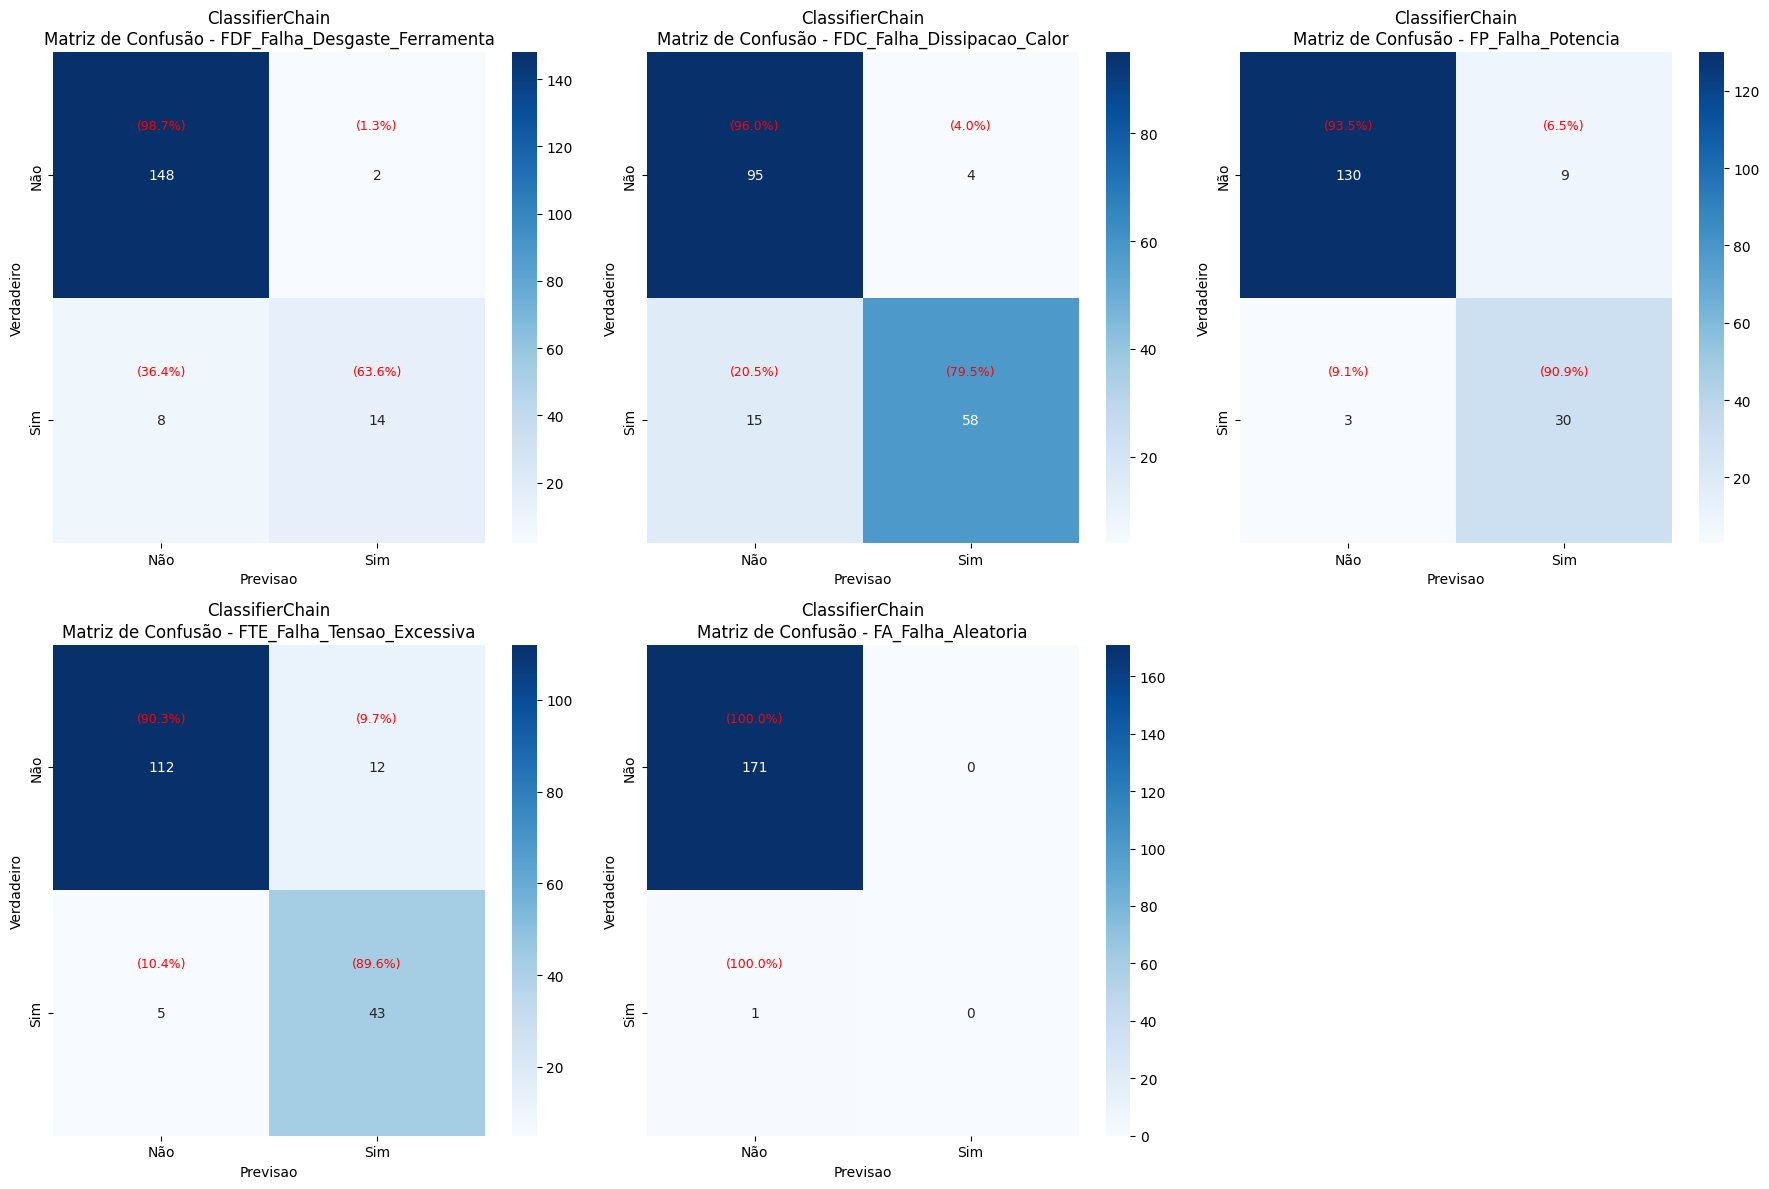

In [209]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Defina o modelo que você quer avaliar
y_pred = y_pred_chain  # Use as previsões do modelo escolhido

# Crie uma figura
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, coluna in enumerate(target_columns):
    # Verificar se há dados para esta label no teste
    if y_test[coluna].sum() == 0 and (y_pred[:, i].sum() == 0):
        # Caso especial: nenhum exemplo positivo no teste e nenhuma previsão positiva
        axes[i].text(0.5, 0.5, f'Nenhum dado de teste\npara {coluna}',
                    ha='center', va='center', fontsize=12)
        axes[i].set_title(f'Matriz de Confusão - {coluna}')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        continue

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test[coluna], y_pred[:, i])

    # Garantir que a matriz seja 2x2 (pode ser 1x1 ou 1x2 em casos extremos)
    if cm.shape == (1, 1):
        # Expandir para 2x2 preenchendo com zeros
        cm_full = np.zeros((2, 2), dtype=int)
        cm_full[0, 0] = cm[0, 0]  # TN
    elif cm.shape == (1, 2):
        cm_full = np.zeros((2, 2), dtype=int)
        cm_full[0, :] = cm[0, :]  # TN e FP
    elif cm.shape == (2, 1):
        cm_full = np.zeros((2, 2), dtype=int)
        cm_full[:, 0] = cm[:, 0]  # TN e FN
    else:
        cm_full = cm

    # Calcular percentuais (evitando divisão por zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_percent = np.zeros_like(cm_full, dtype=float)
        row_sums = cm_full.sum(axis=1)
        for j in range(cm_full.shape[0]):
            if row_sums[j] > 0:
                cm_percent[j, :] = cm_full[j, :].astype('float') / row_sums[j] * 100
            else:
                cm_percent[j, :] = 0

    # Plotar heatmap
    sns.heatmap(cm_full, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])

    # Adicionar percentuais
    for j in range(cm_full.shape[0]):
        for k in range(cm_full.shape[1]):
            if cm_full[j, k] > 0:  # Só adiciona texto se houver valor
                axes[i].text(k + 0.5, j + 0.3, f'({cm_percent[j, k]:.1f}%)',
                           ha='center', va='center', color='red', fontsize=9)

    axes[i].set_title(f'ClassifierChain\nMatriz de Confusão - {coluna}')
    axes[i].set_xlabel('Previsao')
    axes[i].set_ylabel('Verdadeiro')

# Remover subplots vazios
for j in range(len(target_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('report_multilabel\chain_confusion_matrixes_multilabel.png')
plt.show()

In [195]:
# Analisar cada label individualmente
for i, coluna in enumerate(target_columns):
    print(f"\n=== Análise para {coluna} ===\n")

    try:
        cm = confusion_matrix(y_test[coluna], y_pred[:, i])
        print("Matriz de Confusão:")
        print(cm)

        # Extrair TN, FP, FN, TP (cuidado com matrizes não-2x2)
        if cm.size == 1:
            tn = cm[0, 0]
            fp, fn, tp = 0, 0, 0
        elif cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            print("Matriz com formato inesperado")
            continue

        print(f"\nVerdadeiros Negativos (TN): {tn}")
        print(f"Falsos Positivos (FP): {fp}")
        print(f"Falsos Negativos (FN): {fn}")
        print(f"Verdadeiros Positivos (TP): {tp}")

    except Exception as e:
        print(f"Erro ao calcular matriz para {coluna}: {e}")


=== Análise para FDF_Falha_Desgaste_Ferramenta ===

Matriz de Confusão:
[[148   2]
 [  8  14]]

Verdadeiros Negativos (TN): 148
Falsos Positivos (FP): 2
Falsos Negativos (FN): 8
Verdadeiros Positivos (TP): 14

=== Análise para FDC_Falha_Dissipacao_Calor ===

Matriz de Confusão:
[[95  4]
 [15 58]]

Verdadeiros Negativos (TN): 95
Falsos Positivos (FP): 4
Falsos Negativos (FN): 15
Verdadeiros Positivos (TP): 58

=== Análise para FP_Falha_Potencia ===

Matriz de Confusão:
[[130   9]
 [  3  30]]

Verdadeiros Negativos (TN): 130
Falsos Positivos (FP): 9
Falsos Negativos (FN): 3
Verdadeiros Positivos (TP): 30

=== Análise para FTE_Falha_Tensao_Excessiva ===

Matriz de Confusão:
[[112  12]
 [  5  43]]

Verdadeiros Negativos (TN): 112
Falsos Positivos (FP): 12
Falsos Negativos (FN): 5
Verdadeiros Positivos (TP): 43

=== Análise para FA_Falha_Aleatoria ===

Matriz de Confusão:
[[171   0]
 [  1   0]]

Verdadeiros Negativos (TN): 171
Falsos Positivos (FP): 0
Falsos Negativos (FN): 1
Verdadeiros P

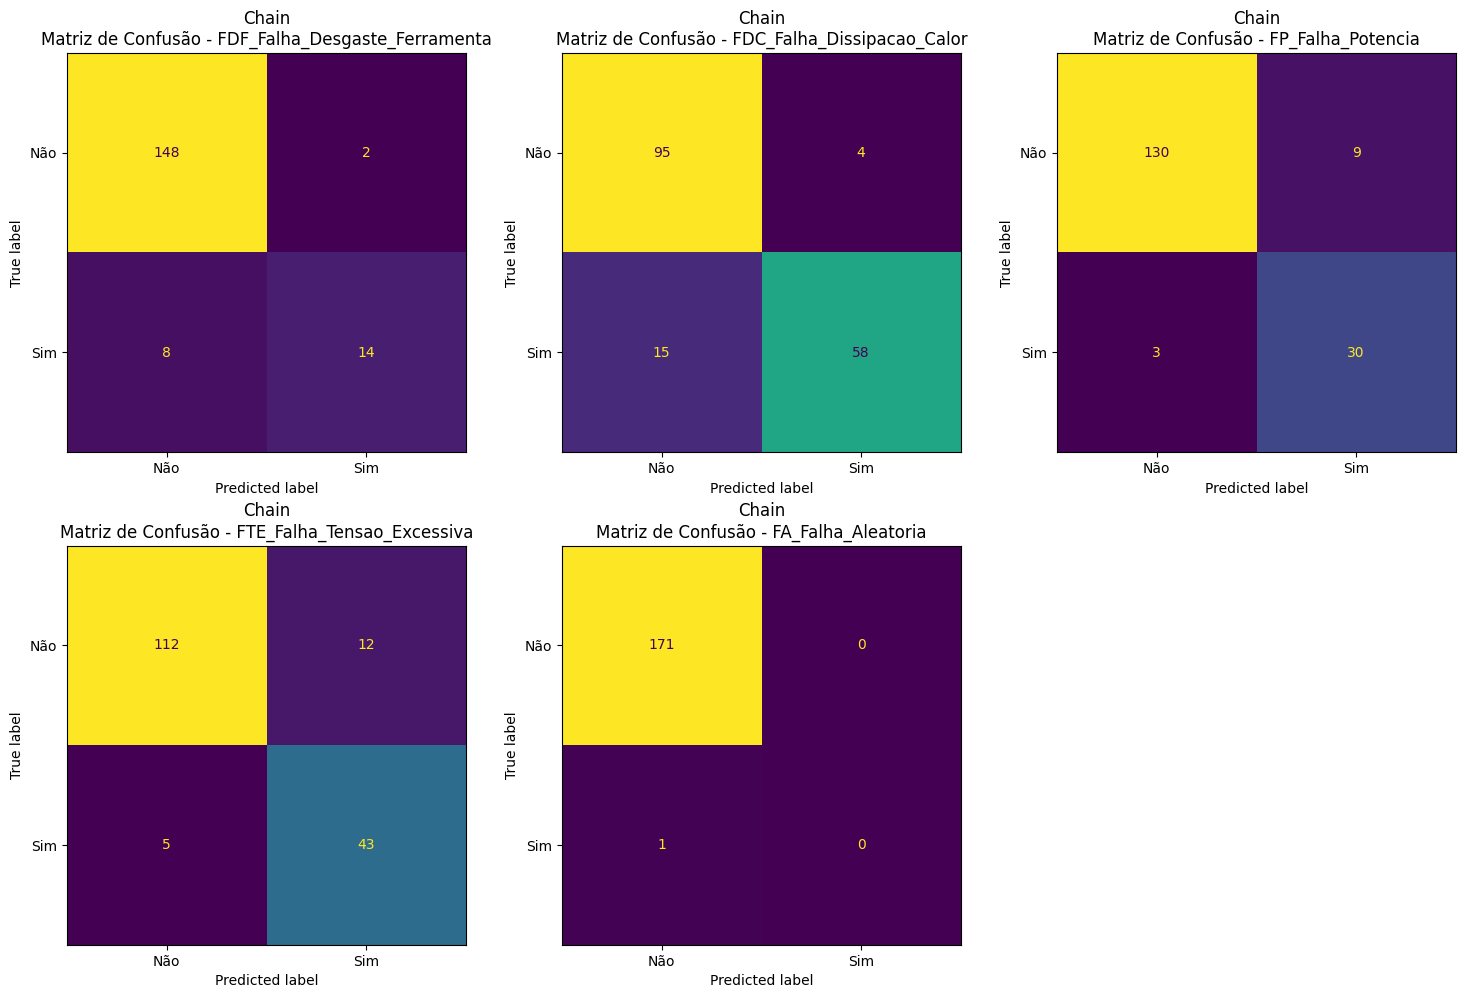

In [140]:
# Crie uma figura
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, coluna in enumerate(target_columns):
    try:
        # Tentar criar a matriz de confusão normalmente
        cm = confusion_matrix(y_test[coluna], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Não', 'Sim'])
        disp.plot(ax=axes[i], values_format='d', colorbar=False)
        axes[i].set_title(f'Chain\nMatriz de Confusão - {coluna}')
    except Exception as e:
        # Se der erro, mostrar mensagem informativa
        #axes[i].text(0.5, 0.5, f'Erro: Sem dados',
                    #ha='center', va='top', fontsize=10)
        axes[i].set_title(f'{coluna} - Erro na matriz / Sem dados')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

# Remover subplots vazios
for j in range(len(target_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()